In [2]:
library(ArchR)
library(Seurat)
library(dplyr)
library(tidyr)
library(parallel)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(WebGestaltR)
library(RColorBrewer)
library(ggsci)
library(rbioapi)
library(ComplexHeatmap)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [3]:
projdir <- '/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis'

addArchRGenome("mm10")
addArchRThreads(threads = 45) 

MuSC_projAging1 <- readRDS(file.path(projdir, "MuSC_subset", "all_MuSCs", "Save-ArchR-Project.rds"))

Setting default genome to Mm10.

Setting default number of Parallel threads to 45.



In [4]:
source(file.path(projdir, 'ArchR_utilities.R'))

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: mclust

Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.

Loading required package: GenomicInteractions

Loading required package: InteractionSet

Loading required package: doParallel

Loading required package: foreach

Loading required package: iterators

Loading required package: maxmatching



In [5]:
clustered_p2g <- readRDS(file.path(projdir, 'MuSC_subset', 'all_MuSCs', 'all_MuSC_peak2gene_clustered.RDS'))

# Annotate peaks in P2G

In [155]:
peakset <- metadata(clustered_p2g$Peak2GeneLinks)$peakSet # get all peaks in ArchR object
geneset <- metadata(clustered_p2g$Peak2GeneLinks)$geneSet # get all genes in ArchR object

In [156]:
p2g_peakset <- peakset[clustered_p2g$Peak2GeneLinks$idxATAC,] # get peaks in P2G linkages
p2g_peakset$kmeansId <- clustered_p2g$ATAC$kmeansId # add kmeans ID
p2g_peakset$gene <- geneset$name[clustered_p2g$Peak2GeneLinks$idxRNA] # add genes 

In [174]:
clustered_p2g$Peak2GeneLinks

DataFrame with 65536 rows and 8 columns
            idxATAC    idxRNA Correlation         FDR  VarQATAC   VarQRNA
          <integer> <integer>   <numeric>   <numeric> <numeric> <numeric>
P2G_1             7         4    0.454769 5.88061e-32  0.293608  0.922860
P2G_2             7         5    0.541045 5.18773e-47  0.293608  0.893475
P2G_3             4         7    0.643624 9.84521e-72  0.896414  0.598969
P2G_4             7         7    0.571748 1.65559e-53  0.293608  0.598969
P2G_5            25        16    0.464745 1.73906e-33  0.836118  0.990264
...             ...       ...         ...         ...       ...       ...
P2G_65532     54371     22683    0.546261 4.54985e-48  0.455909  0.797921
P2G_65533     54386     22688    0.495334 1.67862e-38  0.757367  0.926208
P2G_65534     54381     22691    0.491559 7.43999e-38  0.402324  0.552227
P2G_65535     54394     22696    0.482208 2.75128e-36  0.898969  0.887572
P2G_65536     54394     22697    0.559641 7.26561e-51  0.898969  0.77831

In [158]:
p2g_peakset; peakset

GRanges object with 65536 ranges and 2 metadata columns:
          seqnames              ranges strand |  kmeansId    gene
             <Rle>           <IRanges>  <Rle> | <integer> <array>
      [1]     chr1     4858369-4858869      * |         2  Mrpl15
      [2]     chr1     4858369-4858869      * |         2  Lypla1
      [3]     chr1     4785442-4785942      * |         2   Rgs20
      [4]     chr1     4858369-4858869      * |         2   Rgs20
      [5]     chr1     9943880-9944380      * |         4    Rrs1
      ...      ...                 ...    ... .       ...     ...
  [65532]     chrX 166344517-166345017      * |         1    Rab9
  [65533]     chrX 167382544-167383044      * |         2  Tmsb4x
  [65534]     chrX 167049211-167049711      * |         4   Prps2
  [65535]     chrX 169320154-169320654      * |         4    Hccs
  [65536]     chrX 169320154-169320654      * |         4    Mid1
  -------
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

GRanges object with 54399 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
      [1]     chr1     3670539-3671039      *
      [2]     chr1     3671560-3672060      *
      [3]     chr1     4571643-4572143      *
      [4]     chr1     4785442-4785942      *
      [5]     chr1     4807545-4808045      *
      ...      ...                 ...    ...
  [54395]     chrX 169862852-169863352      *
  [54396]     chrX 169879276-169879776      *
  [54397]     chrX 169881271-169881771      *
  [54398]     chrX 169881820-169882320      *
  [54399]     chrX 169890719-169891219      *
  -------
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

## Annotate P2G linkages by location of peak (duplicate peaks annotated)

In [161]:
peakset_anno <- annotatePeak(p2g_peakset, tssRegion=c(-1000,1000), 
                             TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene, annoDb = "org.Mm.eg.db")

>> preparing features information...		 2022-12-23 11:19:26 PM 
>> identifying nearest features...		 2022-12-23 11:19:26 PM 
>> calculating distance from peak to TSS...	 2022-12-23 11:19:27 PM 
>> assigning genomic annotation...		 2022-12-23 11:19:27 PM 
>> adding gene annotation...			 2022-12-23 11:19:30 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-12-23 11:19:30 PM 
>> done...					 2022-12-23 11:19:30 PM 


In [163]:
peakset_anno; peakset_anno@anno

Annotated peaks generated by ChIPseeker
65536/65536  peaks were annotated
Genomic Annotation Summary:
             Feature  Frequency
9           Promoter 54.3594360
4             5' UTR  0.3372192
3             3' UTR  2.9602051
1           1st Exon  1.5731812
7         Other Exon  4.3945312
2         1st Intron  9.0682983
8       Other Intron 10.5819702
6 Downstream (<=300)  0.1617432
5  Distal Intergenic 16.5634155

GRanges object with 65536 ranges and 14 metadata columns:
          seqnames              ranges strand |  kmeansId    gene
             <Rle>           <IRanges>  <Rle> | <integer> <array>
      [1]     chr1     4858369-4858869      * |         2  Mrpl15
      [2]     chr1     4858369-4858869      * |         2  Lypla1
      [3]     chr1     4785442-4785942      * |         2   Rgs20
      [4]     chr1     4858369-4858869      * |         2   Rgs20
      [5]     chr1     9943880-9944380      * |         4    Rrs1
      ...      ...                 ...    ... .       ...     ...
  [65532]     chrX 166344517-166345017      * |         1    Rab9
  [65533]     chrX 167382544-167383044      * |         2  Tmsb4x
  [65534]     chrX 167049211-167049711      * |         4   Prps2
  [65535]     chrX 169320154-169320654      * |         4    Hccs
  [65536]     chrX 169320154-169320654      * |         4    Mid1
                 annotation   geneChr geneStart   geneEnd geneLength geneStrand
    

In [167]:
peakset_anno.df <- as.data.frame(peakset_anno@anno)
peakset_anno.df

seqnames start     end       width strand kmeansId gene     
1     chr1      4858369   4858869  501   *      2        Mrpl15   
2     chr1      4858369   4858869  501   *      2        Lypla1   
3     chr1      4785442   4785942  501   *      2        Rgs20    
4     chr1      4858369   4858869  501   *      2        Rgs20    
5     chr1      9943880   9944380  501   *      4        Rrs1     
6     chr1      9747640   9748140  501   *      2        Adhfe1   
7     chr1      9797888   9798388  501   *      2        Adhfe1   
8     chr1      9848041   9848541  501   *      3        Adhfe1   
9     chr1      9967167   9967667  501   *      2        Adhfe1   
10    chr1      9967972   9968472  501   *      2        Adhfe1   
11    chr1     10037702  10038202  501   *      2        Adhfe1   
12    chr1     10039494  10039994  501   *      2        Adhfe1   
13    chr1      9545892   9546392  501   *      2        Mybl1    
14    chr1     10008845  10009345  501   *      3        Sgk3     
15    chr1      9797888   9798388  501   *      2        Mcmdc2   
16    chr1     10232826  10233326  501   *      1        Mcmdc2   
17    chr1      9797888   9798388  501   *      2        Tcf24    
18    chr1      9545064   9545564  501   *      5        Cops5    
19    chr1      9700195   9700695  501   *      5        Cops5    
20    chr1      9747640   9748140  501   *      2        Cspp1    
21    chr1     10039494  10039994  501   *      2        Cspp1    
22    chr1     10232184  10232684  501   *      3        Cspp1    
23    chr1     11177659  11178159  501   *      4        Prex2    
24    chr1     12291735  12292235  501   *      4        Sulf1    
25    chr1     12571770  12572270  501   *      4        Sulf1    
26    chr1     12612024  12612524  501   *      4        Sulf1    
27    chr1     12715341  12715841  501   *      4        Sulf1    
28    chr1     12718102  12718602  501   *      4        Sulf1    
29    chr1     12734317  12734817  501   *      4        Sulf1    
30    chr1     12571770  12572270  501   *      4        Slco5a1  
⋮     ⋮        ⋮         ⋮         ⋮     ⋮      ⋮        ⋮        
65507 chrX     162510584 162511084 501   *      4        Txlng    
65508 chrX     162735545 162736045 501   *      4        Txlng    
65509 chrX     162888202 162888702 501   *      5        Syap1    
65510 chrX     162510584 162511084 501   *      4        Ctps2    
65511 chrX     162643368 162643868 501   *      4        Ctps2    
65512 chrX     162735545 162736045 501   *      4        Ctps2    
65513 chrX     162888202 162888702 501   *      5        Ctps2    
65514 chrX     162901270 162901770 501   *      2        S100g    
65515 chrX     163957968 163958468 501   *      1        Rnf138rt1
65516 chrX     164269320 164269820 501   *      3        Ap1s2    
65517 chrX     164269320 164269820 501   *      3        Car5b    
65518 chrX     164269320 164269820 501   *      3        Siah1b   
65519 chrX     163908078 163908578 501   *      4        Pir      
65520 chrX     164075965 164076465 501   *      5        Pir      
65521 chrX     164381865 164382365 501   *      5        Pir      
65522 chrX     164419236 164419736 501   *      5        Pir      
65523 chrX     164269320 164269820 501   *      3        Vegfd    
65524 chrX     163938525 163939025 501   *      4        Piga     
65525 chrX     164027886 164028386 501   *      4        Piga     
65526 chrX     166170157 166170657 501   *      2        Gemin8   
65527 chrX     166170157 166170657 501   *      2        Gpm6b    
65528 chrX     166238682 166239182 501   *      2        Gpm6b    
65529 chrX     166173708 166174208 501   *      1        Rab9     
65530 chrX     166271443 166271943 501   *      1        Rab9     
65531 chrX     166316618 166317118 501   *      1        Rab9     
65532 chrX     166344517 166345017 501   *      1        Rab9     
65533 chrX     167382544 167383044 501   *      2        Tmsb4x   
65534 chrX     167049211 167049711 501   *      4    

In [182]:
colnames(peakset_anno.df)

[1] "seqnames"          "start"             "end"              
 [4] "width"             "strand"            "kmeansId"         
 [7] "gene"              "annotation"        "geneChr"          
[10] "geneStart"         "geneEnd"           "geneLength"       
[13] "geneStrand"        "geneId"            "transcriptId"     
[16] "distanceToTSS"     "ENSEMBL"           "SYMBOL"           
[19] "GENENAME"          "simple_anno"       "even_simpler_anno"

## Replace complex exon and intron labels

In [183]:
peakset_anno.df$simple_anno <- peakset_anno.df$annotation

intron_idx <- grepl("Intron",peakset_anno.df$simple_anno,fixed=TRUE)
exon_idx <- grepl("Exon",peakset_anno.df$simple_anno,fixed=TRUE)

peakset_anno.df$simple_anno[intron_idx] <- sapply(peakset_anno.df$simple_anno[intron_idx],  
                                                 function(x) ifelse(grepl("intron 1 of", x, fixed=TRUE), 
                                                                    "1st Intron", "Other Intron"))
peakset_anno.df$simple_anno[exon_idx] <- sapply(peakset_anno.df$simple_anno[exon_idx],  
                                                 function(x) ifelse(grepl("exon 1 of", x, fixed=TRUE), 
                                                                    "1st Exon", "Other Exon"))

In [184]:
# try annotation without 1st or other exon/intron
even_simpler_anno = c("1st Intron" = "Intron", "Other Intron" = "Intron", "1st Exon" = "Exon", "Other Exon" = "Exon")
peakset_anno.df$even_simpler_anno <- peakset_anno.df$simple_anno
peakset_anno.df$even_simpler_anno[intron_idx] <- even_simpler_anno[peakset_anno.df$simple_anno[intron_idx]]
peakset_anno.df$even_simpler_anno[exon_idx] <- even_simpler_anno[peakset_anno.df$simple_anno[exon_idx]]

peakset_anno.df$simple_anno <- factor(peakset_anno.df$simple_anno, 
                                     levels=c("Promoter","5' UTR", "3' UTR", "1st Exon", "Other Exon", 
                                              "1st Intron", "Other Intron", "Downstream (<=300bp)", "Distal Intergenic"))
peakset_anno.df$even_simpler_anno <- factor(peakset_anno.df$even_simpler_anno, 
                                           levels=c("Promoter","5' UTR", "3' UTR", "Exon", "Intron", "Downstream (<=300bp)", "Distal Intergenic"))


## Plot union peak set annotation

In [185]:
peakset_anno.plt_df = peakset_anno.df %>%
  group_by(even_simpler_anno) %>%
  summarise(Count = n()) %>%
  mutate(anno_frac = Count/sum(Count)) %>%
  ungroup()
peakset_anno.plt_df$frac_label = peakset_anno.plt_df$anno_frac
peakset_anno.plt_df$frac_label[!(peakset_anno.plt_df$even_simpler_anno %in% c("Promoter","Intron","Distal Intergenic"))] = NA

In [208]:
png(file.path(projdir,"output","Peak2GeneLinks","union_peaks_anno_chipseeker.png"), res=300, units='in', width=3.5, height=3.5)
ggplot(peakset_anno.plt_df, aes(x="", y=Count/1e3)) +
  geom_col(aes(fill=even_simpler_anno)) +
  scale_y_continuous(expand=expansion(mult=c(0,0.1))) +
  geom_text(aes(group = even_simpler_anno, label=scales::percent(frac_label,1)), 
            size = 3,
            position=position_stack(vjust = 0.5)) +
  scale_fill_manual(values=brewer.pal(length(unique(peakset_anno.df$even_simpler_anno)),"Paired")) +
  theme_bw() + 
  labs(x="", y="# of Union Peaks (x1000)", fill="Feature") +
  guides(fill = guide_legend(reverse=F)) +
  theme(axis.text=element_text(size=12, face="bold", color="black"),
        axis.title=element_text(size=12, face="bold", color="black"),
        axis.ticks.x = element_blank(),
        legend.title=element_text(face="bold"),
        legend.text=element_text(size=12))
dev.off()

Warning message:
“Removed 4 rows containing missing values (geom_text).”


png 
  2

## Plot cluster-specific peak set annotation

In [198]:
clust_peakset_anno.plt_df <- peakset_anno.df %>%
    group_by(kmeansId, even_simpler_anno) %>%
    summarise(Count = n()) %>%
    mutate(anno_frac = Count/sum(Count)) %>%
    ungroup()
clust_peakset_anno.plt_df$frac_label = clust_peakset_anno.plt_df$anno_frac
clust_peakset_anno.plt_df$frac_label[!(clust_peakset_anno.plt_df$even_simpler_anno %in% c("Promoter","Intron","Distal Intergenic"))] = NA

`summarise()` has grouped output by 'kmeansId'. You can override using the `.groups` argument.


In [209]:
png(file.path(projdir,"output","Peak2GeneLinks","cluster_peaks_anno_chipseeker.png"), res=300, units='in', width=5, height=3.5)
ggplot(clust_peakset_anno.plt_df, aes(x=kmeansId, y=Count/1e3)) +
  geom_col(aes(fill=even_simpler_anno)) +
  scale_y_continuous(expand=expansion(mult=c(0,0.1))) +
  geom_text(aes(group = even_simpler_anno, label=scales::percent(frac_label,1)), 
            size = 3,
            position=position_stack(vjust = 0.5)) +
  scale_fill_manual(values=brewer.pal(length(unique(peakset_anno.df$even_simpler_anno)),"Paired")) +
  theme_bw() + 
  labs(x="", y="# of Union Peaks (x1000)", fill="Feature") +
  guides(fill = guide_legend(reverse=F)) +
  theme(axis.text=element_text(size=12, face="bold", color="black"),
        axis.title=element_text(size=12, face="bold", color="black"),
        axis.ticks.x = element_blank(),
        legend.title=element_text(face="bold"),
        legend.text=element_text(size=12))
dev.off()

Warning message:
“Removed 20 rows containing missing values (geom_text).”


png 
  2

# Look at expression of genes marked by P2G linkages

## Get gene score and gene expression matrices

In [260]:
MuSC_projAging1 <- addImputeWeights(MuSC_projAging1)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-8c9a2b1f1e98-Date-2022-12-24_Time-00-23-28.log
If there is an issue, please report to github with logFile!

2022-12-24 00:23:28 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)



In [261]:
getAvailableMatrices(MuSC_projAging1)

[1] "GeneScoreMatrix"                     "Harmony_4iter_GeneIntegrationMatrix"
[3] "PeakMatrix"                          "TileMatrix"

In [228]:
gene_score_mat <- getMatrixFromProject(MuSC_projAging1, useMatrix = 'GeneScoreMatrix')

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-8c9a7a0b08b2-Date-2022-12-24_Time-00-09-40.log
If there is an issue, please report to github with logFile!

2022-12-24 00:09:48 : Organizing colData, 0.132 mins elapsed.

2022-12-24 00:09:48 : Organizing rowData, 0.137 mins elapsed.

2022-12-24 00:09:48 : Organizing rowRanges, 0.137 mins elapsed.

2022-12-24 00:09:48 : Organizing Assays (1 of 1), 0.137 mins elapsed.

2022-12-24 00:09:48 : Constructing SummarizedExperiment, 0.14 mins elapsed.

2022-12-24 00:09:50 : Finished Matrix Creation, 0.175 mins elapsed.



In [268]:
magic_score_mat <- imputeMatrix(assays(gene_score_mat)[[1]], imputeWeights = getImputeWeights(MuSC_projAging1))

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-imputeMatrix-8c9a455a1632-Date-2022-12-24_Time-00-25-44.log
If there is an issue, please report to github with logFile!

Using weights on disk

1 of 1



In [272]:
assays(gene_score_mat)$MagicScoreMatrix <- magic_score_mat

In [229]:
rna_exp_mat <- getMatrixFromProject(MuSC_projAging1, useMatrix = 'Harmony_4iter_GeneIntegrationMatrix')

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-8c9a5e828db4-Date-2022-12-24_Time-00-10-02.log
If there is an issue, please report to github with logFile!

2022-12-24 00:10:11 : Organizing colData, 0.153 mins elapsed.

2022-12-24 00:10:11 : Organizing rowData, 0.158 mins elapsed.

2022-12-24 00:10:11 : Organizing rowRanges, 0.158 mins elapsed.

2022-12-24 00:10:11 : Organizing Assays (1 of 1), 0.158 mins elapsed.

2022-12-24 00:10:12 : Constructing SummarizedExperiment, 0.165 mins elapsed.

2022-12-24 00:10:14 : Finished Matrix Creation, 0.197 mins elapsed.



## Get frequency of genes marked by P2G linkages

In [277]:
gene_p2g_freq <- as.data.frame(table(clustered_p2g$Peak2GeneLinks$gene))
colnames(gene_p2g_freq) <- c("gene", "Freq")
head(gene_p2g_freq)

gene          Freq
1 0610009B22Rik  4  
2 0610009L18Rik 12  
3 0610010K14Rik 22  
4 0610012G03Rik  8  
5 0610030E20Rik 13  
6 0610031O16Rik 13

In [278]:
# column indices for aged and young MuSCs
aged_score_idx <- colData(gene_score_mat)$Age=="Aged"
young_score_idx <- colData(gene_score_mat)$Age=="Young"
aged_rna_idx <- colData(rna_exp_mat)$Age=="Aged"
young_rna_idx <- colData(rna_exp_mat)$Age=="Young"

In [241]:
rowData(rna_exp_mat)

DataFrame with 22699 rows and 6 columns
      seqnames     start       end  strand          name     idx
         <Rle>   <array>   <array> <array>       <array> <array>
1         chr1   3671498   3214482       2          Xkr4       1
2         chr1   4409241   4290846       2           Rp1       2
3         chr1   4497354   4490928       2         Sox17       3
4         chr1   4785726   4773198       2        Mrpl15       4
5         chr1   4807893   4846735       1        Lypla1       5
...        ...       ...       ...     ...           ...     ...
22695     chrX 169187209 169176114       2         Amelx     918
22696     chrX 169320372 169251538       2          Hccs     919
22697     chrX 169685199 169990798       1          Mid1     920
22698     chrX 169779635 169776378       2 4933400A11Rik     921
22699     chrX 170672644 170678054       1          Asmt     922

In [279]:
# row indices for genes
gene_idx <- which(rowData(rna_exp_mat)$name %in% gene_p2g_freq$gene)
score_idx <- which(rowData(gene_score_mat)$name %in% gene_p2g_freq$gene)

In [280]:
magic_score_dcg <- assays(gene_score_mat)[['MagicScoreMatrix']]
rna_exp_dcg <- assays(rna_exp_mat)[['Harmony_4iter_GeneIntegrationMatrix']]

In [281]:
# add mean expression and standard deviation for each gene
gene_p2g_freq$aged_score_mean <- rowMeans(magic_score_dcg[score_idx, aged_score_idx], na.rm=TRUE)
gene_p2g_freq$young_score_mean <- rowMeans(magic_score_dcg[score_idx, young_score_idx], na.rm=TRUE)

gene_p2g_freq$aged_rna_mean <- rowMeans(rna_exp_dcg[gene_idx, aged_rna_idx], na.rm=TRUE)
gene_p2g_freq$young_rna_mean <- rowMeans(rna_exp_dcg[gene_idx, young_rna_idx], na.rm=TRUE)

In [282]:
gene_p2g_freq

gene          Freq aged_score_mean young_score_mean aged_rna_mean
1     0610009B22Rik  4   0.26906045      0.24053652       0.367744723  
2     0610009L18Rik 12   0.23948034      0.18800951       0.144895767  
3     0610010K14Rik 22   0.10022226      0.07574318       0.018269139  
4     0610012G03Rik  8   1.05588246      1.02126675       0.646998152  
5     0610030E20Rik 13   0.49378123      0.45562460       0.044183466  
6     0610031O16Rik 13   0.66495263      0.66643208       0.018206665  
7     0610037L13Rik  4   0.27925441      0.21625708       0.055272767  
8     0610040B10Rik  2   0.08350749      0.05336514       0.001663708  
9     0610043K17Rik  1   0.23953021      0.09703326       0.007753728  
10    1110002L01Rik  3   0.69141332      0.53442848       0.324724355  
11    1110004F10Rik  9   0.48842495      0.35828422       0.353955715  
12    1110006O24Rik  4   0.66013852      0.41613071       0.125396119  
13    1110008L16Rik  2   0.92574640      0.67675528       0.540137389  
14    1110008P14Rik 35   0.37608482      0.26220463       0.028911288  
15    1110020A21Rik  1   0.49636643      0.44545276       0.443764680  
16    1110032A03Rik  3   0.26086984      0.26266578       0.058153494  
17    1110038B12Rik 12   0.46383887      0.37677166       0.085273570  
18    1110038F14Rik  1   0.90693739      0.71908291       0.714322415  
19    1110046J04Rik  3   0.18612520      0.12287342       0.005269677  
20    1110051M20Rik 14   0.37250780      0.34422663       0.365526526  
21    1110059E24Rik  3   0.15075988      0.10198915       0.027503973  
22    1110059G10Rik  1   0.37788341      0.30798292       0.057172949  
23    1190005I06Rik 10   0.31780371      0.24453719       0.058826328  
24    1190007I07Rik  1   0.48179873      0.57928876       0.004760913  
25    1300002E11Rik  9   1.33581765      1.46072790       0.070511908  
26    1300017J02Rik  4   0.27612428      0.21697839       0.025962200  
27    1500009L16Rik  1   0.89698817      0.93483134       0.203945096  
28    1500011B03Rik  5   0.42787571      0.37729576       0.124862786  
29    1500015A07Rik  2   0.55002339      0.61970507       0.680083678  
30    1500015O10Rik  2   0.51920576      0.49702940       0.661149495  
⋮     ⋮             ⋮    ⋮               ⋮                ⋮            
10468 Znrd1          4   0.6835688       0.65119093        0.327160968 
10469 Znrd1as        7   0.1806091       0.14729933        0.739877370 
10470 Znrf1         10   0.3155938       0.33001259        0.802224557 
10471 Znrf2         11   0.1696833       0.16487134        0.097209990 
10472 Znrf3          8   0.6330966       0.79784298        0.417116664 
10473 Zpbp2          9   0.3799387       0.53702204        1.329956998 
10474 Zpr1           3   0.4489639       0.32034892        0.017912339 
10475 Zranb1        12   0.3664785       0.36931864        0.588962639 
10476 Zranb2         2   0.3441909       0.31595370        0.093851709 
10477 Zranb3         7   0.5135640       0.34714168        0.091996218 
10478 Zrsr1          5   0.3968779       0.31964678        0.121009919 
10479 Zscan12        7   0.6103957       0.65446432        2.177498543 
10480 Zscan2        15   0.3667791       0.36759557        0.274023364 
10481 Zscan20        9   0.2503067       0.29681102        0.400481231 
10482 Zscan21        1   0.3282983       0.27680855        0.153050767 
10483 Zscan26        6   0.1777626       0.11893309        0.007950246 
10484 Zscan29       10   0.1719347       0.17660241        0.005589999 
10485 Zswim1        12   0.5612198       0.55343551        0.233140902 
10486 Zswim3         2   0.2878731       0.30696253        0.058637269 
10487 Zswim4        11   0.6408211       0.72961286        0.029390305 
10488 Zswim7         2   0.1578706       0.09167103        0.195742784 
10489 Zswim8         8   0.2288937       0.22391952        0.002955387 
10490 Zw10           3   0.5689811       0.70377942        0.073506574 
10491 Zwilch        13   0.2569140       0.183

Warning message:
“Removed 73 rows containing non-finite values (stat_binhex).”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”


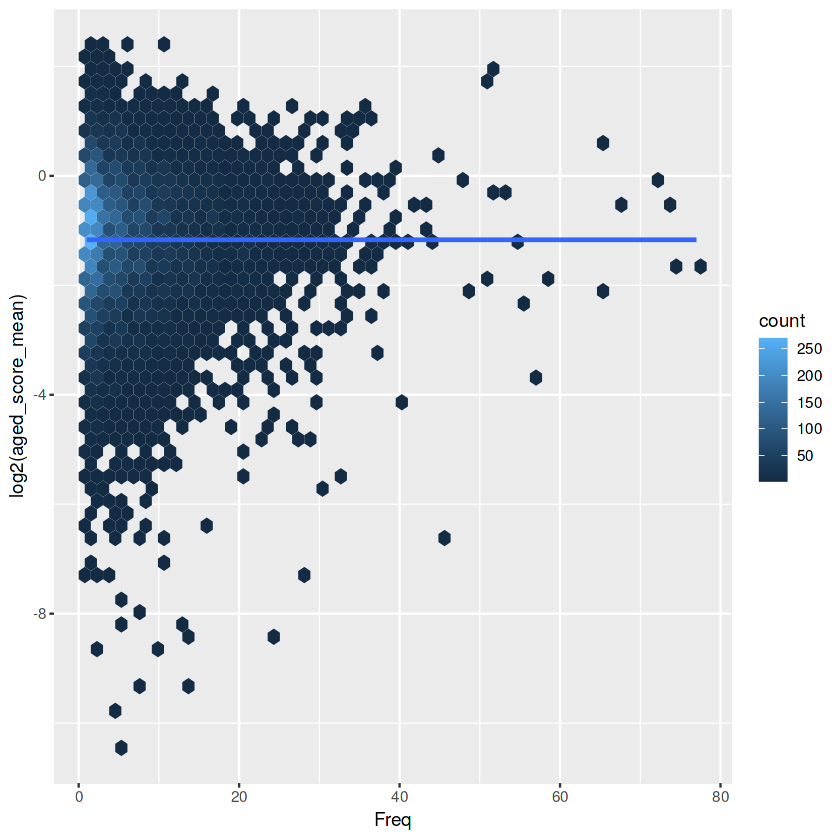

In [287]:
ggplot(gene_p2g_freq, aes(Freq, log2(aged_score_mean))) + geom_hex(bins=50) + geom_smooth()

# P2G linkages in TADs

## Get TAD data and overlaps with P2G

In [291]:
aged.domain <- read.table("/nas/homes/benyang/HiC/08_HiCExplorer/aged.merged/40kb/aged.merged_min120kb_max1200kb_step40kb_thresh0.01_delta_0.01_fdr_domains.bed")
aged.domain.ranges <- GRanges(aged.domain[,1:5] %>% setNames(c("chr","start","end","ID","score")))

young.domain <- read.table("/nas/homes/benyang/HiC/08_HiCExplorer/young.merged/40kb/young.merged_min120kb_max1200kb_step40kb_thresh0.01_delta_0.01_fdr_domains.bed")
young.domain.ranges <- GRanges(young.domain[,1:5] %>% setNames(c("chr","start","end","ID","score")))

In [296]:
aged_domain_hits <- findOverlaps(peakset, aged.domain.ranges, type = "within", ignore.strand = T)
young_domain_hits <- findOverlaps(peakset, young.domain.ranges, type = "within", ignore.strand = T)

In [297]:
peakset$young_TAD <- NA
peakset$young_TAD[young_domain_hits@from] <- young.domain.ranges$ID[young_domain_hits@to]

peakset$aged_TAD <- NA
peakset$aged_TAD[aged_domain_hits@from] <- aged.domain.ranges$ID[aged_domain_hits@to]

In [298]:
peakset

GRanges object with 54399 ranges and 2 metadata columns:
          seqnames              ranges strand |   young_TAD    aged_TAD
             <Rle>           <IRanges>  <Rle> | <character> <character>
      [1]     chr1     3670539-3671039      * |        <NA>        <NA>
      [2]     chr1     3671560-3672060      * |        <NA>        <NA>
      [3]     chr1     4571643-4572143      * |        <NA>        <NA>
      [4]     chr1     4785442-4785942      * |   ID_0.01_1   ID_0.01_1
      [5]     chr1     4807545-4808045      * |   ID_0.01_1   ID_0.01_1
      ...      ...                 ...    ... .         ...         ...
  [54395]     chrX 169862852-169863352      * |        <NA>        <NA>
  [54396]     chrX 169879276-169879776      * |        <NA>        <NA>
  [54397]     chrX 169881271-169881771      * |        <NA>        <NA>
  [54398]     chrX 169881820-169882320      * |        <NA>        <NA>
  [54399]     chrX 169890719-169891219      * |        <NA>        <NA>
  -----

## Count P2G per TAD

In [306]:
# annotate P2G by TAD
p2g_df <- clustered_p2g$Peak2GeneLinks %>%
  as.data.frame() %>%
  mutate(young_TAD = peakset$young_TAD[idxATAC],
         aged_TAD = peakset$aged_TAD[idxATAC])

In [318]:
# count number of unique TADs per gene
p2g_df_stats <- p2g_df %>%
    group_by(gene) %>%
    summarise(young_TAD_per_gene = n_distinct(young_TAD, na.rm=TRUE),
              aged_TAD_per_gene = n_distinct(aged_TAD, na.rm=TRUE)) 
p2g_df_stats

gene          young_TAD_per_gene aged_TAD_per_gene
1     0610009B22Rik 1                  1                
2     0610009L18Rik 2                  1                
3     0610010K14Rik 2                  2                
4     0610012G03Rik 2                  2                
5     0610030E20Rik 2                  1                
6     0610031O16Rik 3                  3                
7     0610037L13Rik 3                  3                
8     0610040B10Rik 1                  1                
9     0610043K17Rik 1                  1                
10    1110002L01Rik 1                  1                
11    1110004F10Rik 2                  2                
12    1110006O24Rik 2                  2                
13    1110008L16Rik 1                  1                
14    1110008P14Rik 3                  1                
15    1110020A21Rik 1                  1                
16    1110032A03Rik 1                  1                
17    1110038B12Rik 2                  2                
18    1110038F14Rik 1                  1                
19    1110046J04Rik 1                  1                
20    1110051M20Rik 2                  2                
21    1110059E24Rik 2                  2                
22    1110059G10Rik 1                  1                
23    1190005I06Rik 2                  2                
24    1190007I07Rik 1                  1                
25    1300002E11Rik 4                  3                
26    1300017J02Rik 1                  1                
27    1500009L16Rik 1                  1                
28    1500011B03Rik 1                  2                
29    1500015A07Rik 2                  2                
30    1500015O10Rik 2                  2                
⋮     ⋮             ⋮                  ⋮                
10468 Znrd1         1                  1                
10469 Znrd1as       1                  1                
10470 Znrf1         1                  2                
10471 Znrf2         2                  2                
10472 Znrf3         1                  1                
10473 Zpbp2         1                  1                
10474 Zpr1          1                  1                
10475 Zranb1        2                  1                
10476 Zranb2        1                  1                
10477 Zranb3        2                  2                
10478 Zrsr1         3                  3                
10479 Zscan12       2                  1                
10480 Zscan2        3                  2                
10481 Zscan20       2                  2                
10482 Zscan21       1                  1                
10483 Zscan26       2                  1                
10484 Zscan29       3                  3                
10485 Zswim1        2                  2                
10486 Zswim3        2                  2                
10487 Zswim4        3                  3                
10488 Zswim7        2                  2                
10489 Zswim8        2                  3                
10490 Zw10          2                  3                
10491 Zwilch        3                  3                
10492 Zxda          1                  1                
10493 Zxdc          2                  2                
10494 Zyg11b        4                  3                
10495 Zyx           1                  1                
10496 Zzef1         1                  1                
10497 Zzz3          3                  2

In [323]:
# Tally TAD per gene frequency
p2g_df_stats <- p2g_df_stats%>%
    pivot_longer(!gene, names_to="Age", values_to="TADs_per_gene") %>%
    group_by(Age, TADs_per_gene) %>%
    tally() %>%
    mutate(Age = factor(Age))

In [324]:
p2g_df_stats

Age                TADs_per_gene n   
1  aged_TAD_per_gene  0              146
2  aged_TAD_per_gene  1             5876
3  aged_TAD_per_gene  2             3491
4  aged_TAD_per_gene  3              898
5  aged_TAD_per_gene  4               81
6  aged_TAD_per_gene  5                5
7  young_TAD_per_gene 0              147
8  young_TAD_per_gene 1             5580
9  young_TAD_per_gene 2             3627
10 young_TAD_per_gene 3             1042
11 young_TAD_per_gene 4               97
12 young_TAD_per_gene 5                4

In [325]:
levels(p2g_df_stats$Age) <- c("aged_TAD_per_gene" = "Aged", "young_TAD_per_gene" = "Young")
p2g_df_stats$Age <- factor(p2g_df_stats$Age, levels=c("Young","Aged"))

In [326]:
png(file.path(projdir,"output","Peak2GeneLinks","TAD_per_p2g_linkage_hist.png"),res=300,units='in',width=4,height=3)
ggplot(p2g_df_stats, aes(x=factor(TADs_per_gene), y=n)) +
  geom_col(aes(fill=Age), col="black", position="dodge") +
  scale_fill_manual(values=pal_nejm()(2)[2:1]) +
  scale_x_discrete(breaks=0:5, labels=0:5) +
  scale_y_continuous(expand = expansion(mult=c(0,0.1))) +
  ggpubr::theme_pubr() + labs(x="# of TADs per Peak-to-Gene Linkage", y="# of Linkages") +
  theme(axis.text = element_text(face="bold"),
        axis.title = element_text(face="bold"),
        legend.title = element_text(face="bold"),
        legend.text = element_text(size=12))
dev.off()

png 
  2

# Gene set analysis of P2G genes

In [5]:
listGeneSet()

name                                           
1  geneontology_Biological_Process                
2  geneontology_Biological_Process_noRedundant    
3  geneontology_Cellular_Component                
4  geneontology_Cellular_Component_noRedundant    
5  geneontology_Molecular_Function                
6  geneontology_Molecular_Function_noRedundant    
7  pathway_KEGG                                   
8  pathway_Panther                                
9  pathway_Reactome                               
10 pathway_Wikipathway                            
11 pathway_Wikipathway_cancer                     
12 network_CORUM                                  
13 network_CORUMA                                 
14 network_CPTAC_Proteomics_BRCA                  
15 network_CPTAC_Proteomics_COADREAD              
16 network_CPTAC_Proteomics_HNSCC                 
17 network_CPTAC_Proteomics_LUAD                  
18 network_CPTAC_Proteomics_OV                    
19 network_CPTAC_Proteomics_UCEC                  
20 network_Kinase_phosphosite                     
21 network_Kinase_target                          
22 network_PPI_BIOGRID                            
23 network_PTMsigDB                               
24 network_TCGA_RNASeq_ACC                        
25 network_TCGA_RNASeq_BLCA                       
26 network_TCGA_RNASeq_BRCA                       
27 network_TCGA_RNASeq_CESC                       
28 network_TCGA_RNASeq_CHOL                       
29 network_TCGA_RNASeq_COADREAD                   
30 network_TCGA_RNASeq_DLBC                       
⋮  ⋮                                              
39 network_TCGA_RNASeq_LIHC                       
40 network_TCGA_RNASeq_LUAD                       
41 network_TCGA_RNASeq_LUSC                       
42 network_TCGA_RNASeq_MESO                       
43 network_TCGA_RNASeq_OV                         
44 network_TCGA_RNASeq_PAAD                       
45 network_TCGA_RNASeq_PCPG                       
46 network_TCGA_RNASeq_PRAD                       
47 network_TCGA_RNASeq_SARC                       
48 network_TCGA_RNASeq_SKCM                       
49 network_TCGA_RNASeq_STAD                       
50 network_TCGA_RNASeq_STES                       
51 network_TCGA_RNASeq_TGCT                       
52 network_TCGA_RNASeq_THCA                       
53 network_TCGA_RNASeq_THYM                       
54 network_TCGA_RNASeq_UCEC                       
55 network_TCGA_RNASeq_UCS                        
56 network_TCGA_RNASeq_UVM                        
57 network_Transcription_Factor_target            
58 network_miRNA_target                           
59 disease_Disgenet                               
60 disease_GLAD4U                                 
61 disease_OMIM                                   
62 drug_DrugBank                                  
63 drug_GLAD4U                                    
64 phenotype_Human_Phenotype_Ontology             
65 chromosomalLocation_CytogeneticBand            
66 community-contributed_5htGeneSets_Conte        
67 community-contributed_Hallmark50               
68 community-contributed_MuscleGeneSets_Duddy_2017
   description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  The gene ontology biological process database was downloaded from http://www.geneontology.org/.                                                                                                                                                                                                                                         

In [6]:
listReferenceSet()

[1] "affy_Axiom_BioBank1"              "affy_Axiom_PMRA"                 
 [3] "affy_Axiom_tx_v1"                 "affy_GenomeWideSNP_5"            
 [5] "affy_GenomeWideSNP_6"             "affy_Mapping10K_Xba142"          
 [7] "affy_Mapping250K_Nsp"             "affy_Mapping250K_Sty"            
 [9] "affy_Mapping50K_Hind240"          "affy_Mapping50K_Xba240"          
[11] "affy_OncoScan"                    "affy_RosettaMerck_Human_RSTA"    
[13] "affy_hc_g110"                     "affy_hg_focus"                   
[15] "affy_hg_u133_plus_2"              "affy_hg_u133a"                   
[17] "affy_hg_u133a_2"                  "affy_hg_u133b"                   
[19] "affy_hg_u95a"                     "affy_hg_u95av2"                  
[21] "affy_hg_u95b"                     "affy_hg_u95c"                    
[23] "affy_hg_u95d"                     "affy_hg_u95e"                    
[25] "affy_hta_2_0"                     "affy_huex_1_0_st_v2"             
[27] "affy_hugene_1_0_st_v1"            "affy_hugene_2_0_st_v1"           
[29] "affy_hugenefl"                    "affy_primeview"                  
[31] "affy_u133_x3p"                    "agilent_cgh_44b"                 
[33] "agilent_gpl6848"                  "agilent_sureprint_g3_ge_8x60k"   
[35] "agilent_sureprint_g3_ge_8x60k_v2" "agilent_wholegenome"             
[37] "agilent_wholegenome_4x44k_v1"     "agilent_wholegenome_4x44k_v2"    
[39] "codelink_codelink"                "genome"                          
[41] "genome_protein-coding"            "illumina_humanht_12_v3"          
[43] "illumina_humanht_12_v4"           "illumina_humanref_8_v3"          
[45] "illumina_humanwg_6_v1"            "illumina_humanwg_6_v2"           
[47] "illumina_humanwg_6_v3"            "phalanx_onearray"                
[49] "phosphosite"

In [38]:
p2g_gene_files <- list.files(file.path(projdir, 'output', 'Peak2GeneLinks'), pattern='.txt')
p2g_gene_files

[1] "all_MuSC_projAging1_p2g_c1.txt" "all_MuSC_projAging1_p2g_c2.txt"
[3] "all_MuSC_projAging1_p2g_c3.txt" "all_MuSC_projAging1_p2g_c4.txt"
[5] "all_MuSC_projAging1_p2g_c5.txt"

In [42]:
webgestaltr_list <- list()
outdir <- file.path(projdir, 'output', 'Peak2GeneLinks', 'WebGestaltR')
if(!dir.exists(outdir)) dir.create(outdir, recursive = TRUE)

for(f in p2g_gene_files) {
    cluster <- gsub(".txt","",f,fixed=TRUE) 
    
    # suppress warnings or 1000s of messages pop up
    suppressWarnings(
        webgestaltr_list[[cluster]] <- WebGestaltR(
        enrichMethod = "ORA",
        organism = "mmusculus",
        enrichDatabase = c("geneontology_Biological_Process_noRedundant",
                           "pathway_Reactome"),
        interestGeneFile = file.path(projdir, 'output', 'Peak2GeneLinks', f),
        interestGeneType = "genesymbol",
        collapseMethod = "mean",
        referenceSet = "genome",
        minNum = 10, maxNum = 2000,
        sigMethod = 'fdr', fdrMethod = 'BH', fdrThr = 0.05,
        reportNum = 40, setCoverNum = 10,
        projectName = cluster,
        isOutput = TRUE, outputDirectory = outdir,
        nThreads = 16
        )
    )
}

Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/output/Peak2GeneLinks/WebGestaltR/Project_all_MuSC_projAging1_p2g_c1!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/output/Peak2GeneLinks/WebGestaltR/Project_all_MuSC_projAging1_p2g_c2!
Loading the functional categories...
Loading the ID list...
Loading 

## Add reactome parent events to group reactome terms together

In [400]:
reactome_list <- list()
for(i in names(webgestaltr_list)) {
    print(i)
    reactome_terms <- webgestaltr_list[[i]] %>% filter(grepl('R-MMU',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)
    reactome_hierarchy_events <- lapply(reactome_terms$geneSet, function(x) rba_reactome_event_ancestors(x)[[1]])
    
    tier1_list = c()
    tier1_id_list = c()
    tier2_list = c()
    tier2_id_list = c()
                                        
    for(j in 1:length(reactome_hierarchy_events)) {
        if(class(reactome_hierarchy_events[[j]]) != "data.frame") {
            tier1_list[j] <- NA
            tier2_list[j] <- NA
            tier1_id_list[j] <- NA
            tier2_id_list[j] <- NA
            next
        }
        idx <- max(1, which(reactome_hierarchy_events[[j]]$schemaClass == 'TopLevelPathway') - 1) # get second to last term before the top level
        max_idx <- which(reactome_hierarchy_events[[j]]$schemaClass == 'TopLevelPathway') # get top level term
        
        tier1_list[j] <- reactome_hierarchy_events[[j]]$displayName[max_idx]
        tier2_list[j] <- reactome_hierarchy_events[[j]]$displayName[idx]
        
        tier1_id_list[j] <- reactome_hierarchy_events[[j]]$stId[max_idx]
        tier2_id_list[j] <- reactome_hierarchy_events[[j]]$stId[idx]
    }

    reactome_terms$tier1_name <- tier1_list
    reactome_terms$tier2_name <- tier2_list
    reactome_terms$tier1_id <- tier1_id_list
    reactome_terms$tier2_id <- tier1_id_list

    reactome_list[[i]] <- reactome_terms     
}

[1] "all_MuSC_projAging1_p2g_c1"


GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /dat

[1] "all_MuSC_projAging1_p2g_c2"


GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /dat

[1] "all_MuSC_projAging1_p2g_c3"


GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /dat

[1] "all_MuSC_projAging1_p2g_c4"


GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /dat

[1] "all_MuSC_projAging1_p2g_c5"


GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /data/event/{id}/ancestorsThe ancestors of a given event

GET /dat

In [407]:
table(reactome_list[[1]]$tier2_name, reactome_list[[1]]$tier1_name)

                                                                
                                                                 Cell Cycle
  Adaptive Immune System                                                  0
  Cell Cycle, Mitotic                                                     2
  Cellular responses to stimuli                                           0
  Gene expression (Transcription)                                         0
  Membrane Trafficking                                                    0
  Metabolism                                                              0
  Metabolism of lipids                                                    0
  Metabolism of nucleotides                                               0
  Metabolism of proteins                                                  0
  Metabolism of RNA                                                       0
  Nervous system development                                              0
  Post-translational pr

In [401]:
saveRDS(webgestaltr_list, file.path(projdir, 'output', 'Peak2GeneLinks', 'WebGestaltR', 'webgestaltr_list.RDS'))
saveRDS(reactome_list, file.path(projdir, 'output', 'Peak2GeneLinks', 'WebGestaltR', 'webgestaltr_reactome_parent_list.RDS'))

In [6]:
reactome_list <- readRDS(file.path(projdir, 'output', 'Peak2GeneLinks', 'WebGestaltR', 'webgestaltr_reactome_parent_list.RDS'))

## Cluster 1
- Vesicle-mediated transport
    - Endosomal Sorting Complex Required For Transport (ESCRT)
    - ER-Phagosome pathway
    - Retrograde transport at the Trans-Golgi-Network
    - Asparagine N-linked glycosylation
    - COPI-mediated anterograde transport
    - Intra-Golgi and retrograde Golgi-to-ER traffic
- Sphingolipid metabolism
    - Glycosphingolipid metabolism
    - Sphingolipid metabolism
- membrane trafficking
    - Rab regulation of trafficking
- nucleotide metabolism
    - Purine catabolism
- mitochondrial biogenesis / activity
    - Mitochondrial translation
    - Respiratory electron transport
    - Complex I biogenesis
    - The citric acid (TCA) cycle and respiratory electron transport
- transcription
    - RNA Polymerase II Pre-transcription Events
    - RNA Polymerase II Transcription Pre-Initiation And Promoter Opening
- Beta-catenin independent WNT signaling

In [66]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c1']] %>% filter(grepl('R-MMU',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet      
1  R-MMU-917729 
2  R-MMU-74259  
3  R-MMU-1236974
4  R-MMU-5419276
5  R-MMU-5368287
6  R-MMU-611105 
7  R-MMU-6811440
8  R-MMU-6799198
9  R-MMU-5389840
10 R-MMU-1660662
11 R-MMU-163200 
12 R-MMU-373755 
13 R-MMU-72766  
14 R-MMU-73776  
15 R-MMU-73779  
16 R-MMU-75953  
17 R-MMU-76042  
18 R-MMU-6807505
19 R-MMU-428157 
20 R-MMU-15869  
21 R-MMU-69017  
22 R-MMU-674695 
23 R-MMU-9007101
24 R-MMU-3858494
25 R-MMU-1236975
26 R-MMU-1428517
27 R-MMU-6807878
28 R-MMU-3700989
29 R-MMU-6811442
30 R-MMU-5633007
31 R-MMU-199991 
32 R-MMU-8951664
33 R-MMU-69275  
34 R-MMU-1483257
35 R-MMU-5653656
36 R-MMU-446203 
37 R-MMU-983169 
38 R-MMU-422475 
39 R-MMU-8953897
40 R-MMU-983168 
41 R-MMU-8953854
42 R-MMU-212436 
43 R-MMU-73857  
44 R-MMU-74160  
45 R-MMU-392499 
46 R-MMU-1430728
47 R-MMU-597592 
   description                                                                                                        
1  Endosomal Sorting Complex Required For Transport (ESCRT)                                                           
2  Purine catabolism                                                                                                  
3  ER-Phagosome pathway                                                                                               
4  Mitochondrial translation termination                                                                              
5  Mitochondrial translation                                                                                          
6  Respiratory electron transport                                                                                     
7  Retrograde transport at the Trans-Golgi-Network                                                                    
8  Complex I biogenesis                                                                                               
9  Mitochondrial translation elongation                                                                               
10 Glycosphingolipid metabolism                                                                                       
11 Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.
12 Semaphorin interactions                                                                                            
13 Translation                                                                                                        
14 RNA Polymerase II Promoter Escape                                                                                  
15 RNA Polymerase II Transcription Pre-Initiation And Promoter Opening                                                
16 RNA Polymerase II Transcription Initiation                                                                         
17 RNA Polymerase II Transcription Initiation And Promoter Clearance                                                  
18 RNA polymerase II transcribes snRNA genes                                                                          
19 Sphingolipid metabolism                                                                                            
20 Metabolism of nucleotides                                                                                          
21 CDK-mediated phosphorylation and removal of Cdc6                                                                   
22 RNA Polymerase II Pre-transcription Events                                                                         
23 Rab regulation of trafficking                                                                                      
24 Beta-catenin independent WNT signaling                                                                             
25 Antigen processing-Cross presentation                                                                              
26 The citric acid (TCA) cycle and respiratory electron transport                            

In [54]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c1']] %>% filter(grepl('GO:',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet    description                                              
1  GO:0019692 deoxyribose phosphate metabolic process                  
2  GO:0006471 protein ADP-ribosylation                                 
3  GO:0009262 deoxyribonucleotide metabolic process                    
4  GO:0071985 multivesicular body sorting pathway                      
5  GO:0007272 ensheathment of neurons                                  
6  GO:0045454 cell redox homeostasis                                   
7  GO:0016197 endosomal transport                                      
8  GO:0007422 peripheral nervous system development                    
9  GO:0007034 vacuolar transport                                       
10 GO:0070585 protein localization to mitochondrion                    
11 GO:0007033 vacuole organization                                     
12 GO:0007051 spindle organization                                     
13 GO:0002181 cytoplasmic translation                                  
14 GO:0043473 pigmentation                                             
15 GO:0006338 chromatin remodeling                                     
16 GO:0061919 process utilizing autophagic mechanism                   
17 GO:1902850 microtubule cytoskeleton organization involved in mitosis
18 GO:1901136 carbohydrate derivative catabolic process                
19 GO:0016482 cytosolic transport                                      
20 GO:0006839 mitochondrial transport                                  
21 GO:0031109 microtubule polymerization or depolymerization           
22 GO:0051348 negative regulation of transferase activity              
23 GO:0007005 mitochondrion organization                               
24 GO:0034404 nucleobase-containing small molecule biosynthetic process
25 GO:0009141 nucleoside triphosphate metabolic process                
26 GO:0009123 nucleoside monophosphate metabolic process               
27 GO:0034976 response to endoplasmic reticulum stress                 
28 GO:0042326 negative regulation of phosphorylation                   
29 GO:0006457 protein folding                                          
30 GO:0006605 protein targeting                                        
⋮  ⋮          ⋮                                                        
35 GO:0006644 phospholipid metabolic process                           
36 GO:0019693 ribose phosphate metabolic process                       
37 GO:0009896 positive regulation of catabolic process                 
38 GO:0010498 proteasomal protein catabolic process                    
39 GO:1902532 negative regulation of intracellular signal transduction 
40 GO:1902115 regulation of organelle assembly                         
41 GO:0072521 purine-containing compound metabolic process             
42 GO:0042063 gliogenesis                                              
43 GO:0022411 cellular component disassembly                           
44 GO:0051098 regulation of binding                                    
45 GO:0045786 negative regulation of cell cycle                        
46 GO:0007346 regulation of mitotic cell cycle                         
47 GO:0090407 organophosphate biosynthetic process                     
48 GO:0042176 regulation of protein catabolic process                  
49 GO:0097193 intrinsic apoptotic signaling pathway                    
50 GO:0045444 fat cell differentiation                                 
51 GO:0016569 covalent chromatin modification                          
52 GO:0009895 negative regulation of catabolic process                 
53 GO:0007568 aging                                                    
54 GO:0030099 myeloid cell differentiation                             
55 GO:0044770 cell cycle phase transition                              
56 GO:0033044 regulation of chromosome organization                    
57 GO:0010256 endomembrane system organization                         
58 GO:2001233 regulation of apoptotic signa

## Cluster 2
- Mitochondrial biogenesis / activity
    - Cristae formation
    - Formation of ATP by chemiosmotic coupling
    - NADH dehydrogenase complex assembly
- eNOS activation and regulation
- mRNA decay 
    - mRNA decay by 3' to 5' exoribonuclease
    - Butyrate Response Factor 1 (BRF1) binds and destabilizes mRNA
- DNA repair 
    - Base Excision Repair
    - Resolution of Abasic Sites (AP sites)
- Cell cycle
    - Cyclin A:Cdk2-associated events at S phase entry
    - S Phase
    - G2/M Transition
    - Cdc20:Phospho-APC/C mediated degradation of Cyclin A
- Hedgehog signaling
    - Signaling by Hedgehog
- MAPK signaling
    - MAPK1/MAPK3 signaling
    - RAF/MAP kinase cascade
    - MAPK family signaling cascades
- DNA repair
    - Nucleotide Excision Repair
- Asparagine N-linked glycosylation

In [328]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c2']] %>% filter(grepl('R-MMU',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet      
1   R-MMU-429958 
2   R-MMU-163210 
3   R-MMU-8949613
4   R-MMU-203615 
5   R-MMU-6799198
6   R-MMU-450385 
7   R-MMU-202131 
8   R-MMU-203765 
9   R-MMU-8949215
10  R-MMU-5389840
11  R-MMU-1592230
12  R-MMU-5368287
13  R-MMU-5419276
14  R-MMU-611105 
15  R-MMU-8949664
16  R-MMU-163200 
17  R-MMU-73884  
18  R-MMU-73933  
19  R-MMU-110373 
20  R-MMU-113418 
21  R-MMU-76071  
22  R-MMU-77075  
23  R-MMU-69656  
24  R-MMU-6811440
25  R-MMU-72766  
26  R-MMU-69202  
27  R-MMU-5696400
28  R-MMU-1428517
29  R-MMU-187577 
30  R-MMU-5696395
⋮   ⋮            
113 R-MMU-948021 
114 R-MMU-3858494
115 R-MMU-1852241
116 R-MMU-5693532
117 R-MMU-69481  
118 R-MMU-71291  
119 R-MMU-3700989
120 R-MMU-5358351
121 R-MMU-6811442
122 R-MMU-2262752
123 R-MMU-1257604
124 R-MMU-8953897
125 R-MMU-5688426
126 R-MMU-1640170
127 R-MMU-5683057
128 R-MMU-5684996
129 R-MMU-5673001
130 R-MMU-212436 
131 R-MMU-69278  
132 R-MMU-199991 
133 R-MMU-69620  
134 R-MMU-983168 
135 R-MMU-983169 
136 R-MMU-392499 
137 R-MMU-8953854
138 R-MMU-597592 
139 R-MMU-5653656
140 R-MMU-73857  
141 R-MMU-74160  
142 R-MMU-1430728
    description                                                                                                        
1   mRNA decay by 3' to 5' exoribonuclease                                                                             
2   Formation of ATP by chemiosmotic coupling                                                                          
3   Cristae formation                                                                                                  
4   eNOS activation                                                                                                    
5   Complex I biogenesis                                                                                               
6   Butyrate Response Factor 1 (BRF1) binds and destabilizes mRNA                                                      
7   Metabolism of nitric oxide                                                                                         
8   eNOS activation and regulation                                                                                     
9   Mitochondrial calcium ion transport                                                                                
10  Mitochondrial translation elongation                                                                               
11  Mitochondrial biogenesis                                                                                           
12  Mitochondrial translation                                                                                          
13  Mitochondrial translation termination                                                                              
14  Respiratory electron transport                                                                                     
15  Processing of SMDT1                                                                                                
16  Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.
17  Base Excision Repair                                                                                               
18  Resolution of Abasic Sites (AP sites)                                                                              
19  Resolution of AP sites via the multiple-nucleotide patch replacement pathway                                       
20  Formation of the Early Elongation Complex                                                                          
21  RNA Polymerase III Transcription Initiation From Type 3 Promoter                                                   
22  RNA Pol II CTD phosphorylation and interaction with CE                                                             
23  Cyclin A:Cdk2-associated events at S phase entry                                                                   
24  Retr

In [73]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c2']] %>% filter(grepl('GO:',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet    description                                              
1  GO:0010257 NADH dehydrogenase complex assembly                      
2  GO:0019692 deoxyribose phosphate metabolic process                  
3  GO:0017004 cytochrome complex assembly                              
4  GO:0009262 deoxyribonucleotide metabolic process                    
5  GO:0031163 metallo-sulfur cluster assembly                          
6  GO:0002181 cytoplasmic translation                                  
7  GO:0070585 protein localization to mitochondrion                    
8  GO:0098732 macromolecule deacylation                                
9  GO:0033619 membrane protein proteolysis                             
10 GO:0140053 mitochondrial gene expression                            
11 GO:0071526 semaphorin-plexin signaling pathway                      
12 GO:0006839 mitochondrial transport                                  
13 GO:0045454 cell redox homeostasis                                   
14 GO:0090559 regulation of membrane permeability                      
15 GO:0007033 vacuole organization                                     
16 GO:0048284 organelle fusion                                         
17 GO:0009141 nucleoside triphosphate metabolic process                
18 GO:0009123 nucleoside monophosphate metabolic process               
19 GO:0007005 mitochondrion organization                               
20 GO:0034394 protein localization to cell surface                     
21 GO:0009451 RNA modification                                         
22 GO:0048193 Golgi vesicle transport                                  
23 GO:0034976 response to endoplasmic reticulum stress                 
24 GO:0007034 vacuolar transport                                       
25 GO:0042594 response to starvation                                   
26 GO:0072521 purine-containing compound metabolic process             
27 GO:0019693 ribose phosphate metabolic process                       
28 GO:0061919 process utilizing autophagic mechanism                   
29 GO:0034404 nucleobase-containing small molecule biosynthetic process
30 GO:0035966 response to topologically incorrect protein              
31 GO:0044770 cell cycle phase transition                              
32 GO:0072524 pyridine-containing compound metabolic process           
33 GO:0010498 proteasomal protein catabolic process                    
34 GO:0030705 cytoskeleton-dependent intracellular transport           
35 GO:0090305 nucleic acid phosphodiester bond hydrolysis              
36 GO:0051186 cofactor metabolic process                               
37 GO:0090407 organophosphate biosynthetic process                     
38 GO:0007051 spindle organization                                     
39 GO:0007346 regulation of mitotic cell cycle                         
40 GO:0008213 protein alkylation                                       
41 GO:0018205 peptidyl-lysine modification                             
42 GO:0006091 generation of precursor metabolites and energy           
43 GO:0032259 methylation                                              
44 GO:0051098 regulation of binding                                    
45 GO:0097191 extrinsic apoptotic signaling pathway                    
46 GO:0016569 covalent chromatin modification                          
47 GO:0097193 intrinsic apoptotic signaling pathway                    
48 GO:0045786 negative regulation of cell cycle                        
49 GO:0006260 DNA replication                                          
50 GO:0042326 negative regulation of phosphorylation                   
51 GO:0071496 cellular response to external stimulus                   
52 GO:0009896 positive regulation of catabolic process                 
53 GO:1902532 negative regulation of intracellular signal transduction 
54 GO:2001233 regulation of apoptotic signaling pathway                
55 GO:0042176 regulation of protein catabol

## Cluster 3
- Mitochondrial activity
    - Formation of ATP by chemiosmotic coupling
    - Cristae formation
    - Mitochondrial biogenesis
    - Mitochondrial calcium ion transport
    - The citric acid (TCA) cycle and respiratory electron transport
    - NADH dehydrogenase complex assembly
- Transcriptional regulation
    - mRNA decay by 3' to 5' exoribonuclease
- Hedgehog signaling
    - Hedgehog 'off' state
    - Hedgehog 'on' state
    - Signaling by Hedgehog
- Golgi transport
    - ER to Golgi Anterograde Transport
    - Transport to the Golgi and subsequent modification
- Cell cycle
    - G1/S Transition
    - Synthesis of DNA
- Asparagine N-linked glycosylation
- DNA Repair
    - Base Excision Repair
    - Resolution of Abasic Sites (AP sites)
    - Gap-filling DNA repair synthesis and ligation in TC-NER
- Transcriptional regulation by RUNX2
- Signaling by TGF-beta family members

In [69]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c3']] %>% filter(grepl('R-MMU',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet      
1  R-MMU-163210 
2  R-MMU-8949613
3  R-MMU-8949215
4  R-MMU-429958 
5  R-MMU-8949664
6  R-MMU-6799198
7  R-MMU-1592230
8  R-MMU-163200 
9  R-MMU-611105 
10 R-MMU-5389840
11 R-MMU-73884  
12 R-MMU-73933  
13 R-MMU-76071  
14 R-MMU-5419276
15 R-MMU-5368287
16 R-MMU-389661 
17 R-MMU-73772  
18 R-MMU-74158  
19 R-MMU-76046  
20 R-MMU-1428517
21 R-MMU-72766  
22 R-MMU-6782210
23 R-MMU-6782135
24 R-MMU-8878166
25 R-MMU-6807505
26 R-MMU-5696398
27 R-MMU-6781827
28 R-MMU-5696399
29 R-MMU-453279 
30 R-MMU-5632684
31 R-MMU-9609507
32 R-MMU-69242  
33 R-MMU-9006936
34 R-MMU-69306  
35 R-MMU-69206  
36 R-MMU-69239  
37 R-MMU-5610787
38 R-MMU-5358351
39 R-MMU-199977 
40 R-MMU-69275  
41 R-MMU-446203 
42 R-MMU-453274 
43 R-MMU-948021 
44 R-MMU-73894  
45 R-MMU-8953854
46 R-MMU-69278  
47 R-MMU-1640170
48 R-MMU-74160  
49 R-MMU-392499 
50 R-MMU-212436 
51 R-MMU-73857  
52 R-MMU-597592 
53 R-MMU-1430728
   description                                                                                                        
1  Formation of ATP by chemiosmotic coupling                                                                          
2  Cristae formation                                                                                                  
3  Mitochondrial calcium ion transport                                                                                
4  mRNA decay by 3' to 5' exoribonuclease                                                                             
5  Processing of SMDT1                                                                                                
6  Complex I biogenesis                                                                                               
7  Mitochondrial biogenesis                                                                                           
8  Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.
9  Respiratory electron transport                                                                                     
10 Mitochondrial translation elongation                                                                               
11 Base Excision Repair                                                                                               
12 Resolution of Abasic Sites (AP sites)                                                                              
13 RNA Polymerase III Transcription Initiation From Type 3 Promoter                                                   
14 Mitochondrial translation termination                                                                              
15 Mitochondrial translation                                                                                          
16 Glyoxylate metabolism and glycine degradation                                                                      
17 RNA Polymerase I Promoter Escape                                                                                   
18 RNA Polymerase III Transcription                                                                                   
19 RNA Polymerase III Transcription Initiation                                                                        
20 The citric acid (TCA) cycle and respiratory electron transport                                                     
21 Translation                                                                                                        
22 Gap-filling DNA repair synthesis and ligation in TC-NER                                                            
23 Dual incision in TC-NER                                                                                            
24 Transcriptional regulation by RUNX2                                                                                
25 RNA polymerase II transcribes snRNA genes                                                                  

In [74]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c3']] %>% filter(grepl('GO:',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet    description                                   
1  GO:0010257 NADH dehydrogenase complex assembly           
2  GO:0071985 multivesicular body sorting pathway           
3  GO:0002181 cytoplasmic translation                       
4  GO:0140053 mitochondrial gene expression                 
5  GO:0060840 artery development                            
6  GO:0009123 nucleoside monophosphate metabolic process    
7  GO:0009141 nucleoside triphosphate metabolic process     
8  GO:0006839 mitochondrial transport                       
9  GO:0048193 Golgi vesicle transport                       
10 GO:0007005 mitochondrion organization                    
11 GO:0042180 cellular ketone metabolic process             
12 GO:0072521 purine-containing compound metabolic process  
13 GO:0072524 pyridine-containing compound metabolic process
14 GO:0019693 ribose phosphate metabolic process            
15 GO:0006260 DNA replication                               
16 GO:0034660 ncRNA metabolic process                       
17 GO:0051186 cofactor metabolic process                    
18 GO:0006281 DNA repair                                    
19 GO:0090407 organophosphate biosynthetic process          
20 GO:0097193 intrinsic apoptotic signaling pathway         
21 GO:0010498 proteasomal protein catabolic process         
22 GO:0006091 generation of precursor metabolites and energy
23 GO:0016311 dephosphorylation                             
   link                                                size overlap expect   
1  http://amigo.geneontology.org/amigo/term/GO:0010257  42   26      8.562139
2  http://amigo.geneontology.org/amigo/term/GO:0071985  31   14      6.319674
3  http://amigo.geneontology.org/amigo/term/GO:0002181  83   33     16.920418
4  http://amigo.geneontology.org/amigo/term/GO:0140053  97   34     19.774465
5  http://amigo.geneontology.org/amigo/term/GO:0060840  92   32     18.755162
6  http://amigo.geneontology.org/amigo/term/GO:0009123 279   97     56.877068
7  http://amigo.geneontology.org/amigo/term/GO:0009141 270   90     55.042324
8  http://amigo.geneontology.org/amigo/term/GO:0006839 166   55     33.840836
9  http://amigo.geneontology.org/amigo/term/GO:0048193 251   79     51.168975
10 http://amigo.geneontology.org/amigo/term/GO:0007005 434  136     88.475439
11 http://amigo.geneontology.org/amigo/term/GO:0042180 182   57     37.102604
12 http://amigo.geneontology.org/amigo/term/GO:0072521 481  148     98.056881
13 http://amigo.geneontology.org/amigo/term/GO:0072524 150   46     30.579069
14 http://amigo.geneontology.org/amigo/term/GO:0019693 443  131     90.310183
15 http://amigo.geneontology.org/amigo/term/GO:0006260 228   67     46.480185
16 http://amigo.geneontology.org/amigo/term/GO:0034660 446  129     90.921765
17 http://amigo.geneontology.org/amigo/term/GO:0051186 488  139     99.483904
18 http://amigo.geneontology.org/amigo/term/GO:0006281 430  122     87.659997
19 http://amigo.geneontology.org/amigo/term/GO:0090407 484  135     98.668462
20 http://amigo.geneontology.org/amigo/term/GO:0097193 284   79     57.896370
21 http://amigo.geneontology.org/amigo/term/GO:0010498 425  118     86.640695
22 http://amigo.geneontology.org/amigo/term/GO:0006091 389  107     79.301719
23 http://amigo.geneontology.org/amigo/term/GO:0016311 442  119     90.106323
   enrichmentRatio pValue       FDR         
1  3.036624        5.307413e-09 2.912926e-06
2  2.215304        1.613668e-03 4.368267e-02
3  1.950306        4.057586e-05 2.599560e-03
4  1.719389        5.428117e-04 2.045655e-02
5  1.706197        9.053371e-04 2.958543e-02
6  1.705432        1.238252e-08 4.025203e-06
7  1.635105        3.623909e-07 4.975109e-05
8  1.625255        7.682974e-05 4.343140e-03
9  1.543904        2.014832e-05 1.760230e-03
10 1.537150        3.293340e-08 6.126594e-06
11 1.536280        3.116166e-04 1.361198e-02
12 1.509328        3.044123e-08 6.126594e-06
13 1.504297        1.817587e-03 4.596582e-02
14 1.450556        2.053396e-06 2.631

## Cluster 4
- Spry regulation of FGF signaling
- NF-kB signaling
    - NF-kB is activated and signals survival
    - IRAK1 recruits IKK complex
    - IRAK1 recruits IKK complex upon TLR7/8 or 9 stimulation
    - RIP-mediated NFkB activation via ZBP1
    - TRAF6 mediated NF-kB activation
    - p75NTR signals via NF-kB
    - TAK1 activates NFkB by phosphorylation and activation of IKKs complex
    - TRIF(TICAM1)-mediated TLR4 signal
    - MyD88-independent TLR4 cascade
- Signalling to RAS
- NOTCH signaling
    - NOTCH1 Intracellular Domain Regulates Transcription
    - Signaling by NOTCH1
    - RUNX3 regulates NOTCH signaling
- Deubiquitination
    - Deubiquitination
    - Synthesis of active ubiquitin: roles of E1 and E2 enzymes
- TGFbeta signaling
    - Downregulation of SMAD2/3:SMAD4 transcriptional activity
    - TGF-beta receptor signaling activates SMADs
- MAPK signaling
    - Gastrin-CREB signalling pathway via PKC and MAPK
    - MAP3K8 (TPL2)-dependent MAPK1/3 activation
    - PTK6 Regulates RHO GTPases, RAS GTPase and MAP kinases
- DDX58/IFIH1-mediated induction of interferon-alpha/beta
- Toll Like Receptor 7/8 (TLR7/8) Cascade

In [75]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c4']] %>% filter(grepl('R-MMU',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet      
1   R-MMU-167044 
2   R-MMU-209560 
3   R-MMU-1295596
4   R-MMU-937039 
5   R-MMU-975144 
6   R-MMU-2122947
7   R-MMU-8941856
8   R-MMU-8866652
9   R-MMU-2173795
10  R-MMU-1810476
11  R-MMU-933542 
12  R-MMU-881907 
13  R-MMU-5684264
14  R-MMU-8849471
15  R-MMU-193639 
16  R-MMU-1606322
17  R-MMU-5673000
18  R-MMU-1980143
19  R-MMU-445989 
20  R-MMU-350054 
21  R-MMU-3371568
22  R-MMU-449836 
23  R-MMU-187687 
24  R-MMU-198725 
25  R-MMU-168928 
26  R-MMU-450302 
27  R-MMU-1834949
28  R-MMU-2173789
29  R-MMU-198753 
30  R-MMU-937041 
⋮   ⋮            
108 R-MMU-1169091
109 R-MMU-2871837
110 R-MMU-166520 
111 R-MMU-2454202
112 R-MMU-6807505
113 R-MMU-5688426
114 R-MMU-5689880
115 R-MMU-168898 
116 R-MMU-9006934
117 R-MMU-212165 
118 R-MMU-449147 
119 R-MMU-5663220
120 R-MMU-5684996
121 R-MMU-5673001
122 R-MMU-1280215
123 R-MMU-2262752
124 R-MMU-74160  
125 R-MMU-3700989
126 R-MMU-5683057
127 R-MMU-983168 
128 R-MMU-8953897
129 R-MMU-76002  
130 R-MMU-73857  
131 R-MMU-109582 
132 R-MMU-597592 
133 R-MMU-199991 
134 R-MMU-212436 
135 R-MMU-1280218
136 R-MMU-392499 
137 R-MMU-168256 
    description                                                          
1   Signalling to RAS                                                    
2   NF-kB is activated and signals survival                              
3   Spry regulation of FGF signaling                                     
4   IRAK1 recruits IKK complex                                           
5   IRAK1 recruits IKK complex upon TLR7/8 or 9 stimulation              
6   NOTCH1 Intracellular Domain Regulates Transcription                  
7   RUNX3 regulates NOTCH signaling                                      
8   Synthesis of active ubiquitin: roles of E1 and E2 enzymes            
9   Downregulation of SMAD2/3:SMAD4 transcriptional activity             
10  RIP-mediated NFkB activation via ZBP1                                
11  TRAF6 mediated NF-kB activation                                      
12  Gastrin-CREB signalling pathway via PKC and MAPK                     
13  MAP3K8 (TPL2)-dependent MAPK1/3 activation                           
14  PTK6 Regulates RHO GTPases, RAS GTPase and MAP kinases               
15  p75NTR signals via NF-kB                                             
16  ZBP1(DAI) mediated induction of type I IFNs                          
17  RAF activation                                                       
18  Signaling by NOTCH1                                                  
19  TAK1 activates NFkB by phosphorylation and activation of IKKs complex
20  Notch-HLH transcription pathway                                      
21  Attenuation phase                                                    
22  Other interleukin signaling                                          
23  Signalling to ERKs                                                   
24  Nuclear Events (kinase and transcription factor activation)          
25  DDX58/IFIH1-mediated induction of interferon-alpha/beta              
26  activated TAK1 mediates p38 MAPK activation                          
27  Cytosolic sensors of pathogen-associated DNA                         
28  TGF-beta receptor signaling activates SMADs                          
29  ERK/MAPK targets                                                     
30  IKK complex recruitment mediated by RIP1                             
⋮   ⋮                                                                    
108 Activation of NF-kappaB in B cells                                   
109 FCERI mediated NF-kB activation                                      
110 Signaling by NTRKs                                                   
111 Fc epsilon receptor (FCERI) signaling                                
112 RNA polymerase II transcribes snRNA genes                            
113 Deubiquitination                                                     
114 Ub-specific processing proteases                                     
11

## Cluster 5
- NF-kB signaling
    - NF-kB is activated and signals survival
    - RIP-mediated NFkB activation via ZBP1
    - TRAF6 mediated NF-kB activation
- ZBP1(DAI) mediated induction of type I IFNs
- Spry regulation of FGF signaling
- Chromatin organization

In [692]:
webgestaltr_list[['all_MuSC_projAging1_p2g_c5']] %>% filter(grepl('R-MMU',geneSet,fixed=TRUE)) %>% arrange(desc(enrichmentRatio), FDR)

geneSet      
1   R-MMU-209560 
2   R-MMU-1606322
3   R-MMU-1810476
4   R-MMU-933542 
5   R-MMU-1295596
6   R-MMU-193639 
7   R-MMU-445989 
8   R-MMU-3371568
9   R-MMU-5357956
10  R-MMU-450302 
11  R-MMU-5684264
12  R-MMU-3134963
13  R-MMU-8875656
14  R-MMU-168928 
15  R-MMU-2559585
16  R-MMU-2173795
17  R-MMU-5205685
18  R-MMU-5357905
19  R-MMU-1834949
20  R-MMU-372708 
21  R-MMU-450321 
22  R-MMU-75893  
23  R-MMU-3371571
24  R-MMU-72187  
25  R-MMU-5205647
26  R-MMU-8866654
27  R-MMU-354192 
28  R-MMU-9006921
29  R-MMU-168164 
30  R-MMU-109688 
⋮   ⋮            
83  R-MMU-2565942
84  R-MMU-5633007
85  R-MMU-2262752
86  R-MMU-73887  
87  R-MMU-8953854
88  R-MMU-202403 
89  R-MMU-8953897
90  R-MMU-168898 
91  R-MMU-5689880
92  R-MMU-2559583
93  R-MMU-3700989
94  R-MMU-69275  
95  R-MMU-453274 
96  R-MMU-74160  
97  R-MMU-3247509
98  R-MMU-4839726
99  R-MMU-73857  
100 R-MMU-1280215
101 R-MMU-449147 
102 R-MMU-5688426
103 R-MMU-212436 
104 R-MMU-195258 
105 R-MMU-9006934
106 R-MMU-69278  
107 R-MMU-1280218
108 R-MMU-1640170
109 R-MMU-597592 
110 R-MMU-168256 
111 R-MMU-168249 
112 R-MMU-392499 
    description                                                                         
1   NF-kB is activated and signals survival                                             
2   ZBP1(DAI) mediated induction of type I IFNs                                         
3   RIP-mediated NFkB activation via ZBP1                                               
4   TRAF6 mediated NF-kB activation                                                     
5   Spry regulation of FGF signaling                                                    
6   p75NTR signals via NF-kB                                                            
7   TAK1 activates NFkB by phosphorylation and activation of IKKs complex               
8   Attenuation phase                                                                   
9   TNFR1-induced NFkappaB signaling pathway                                            
10  activated TAK1 mediates p38 MAPK activation                                         
11  MAP3K8 (TPL2)-dependent MAPK1/3 activation                                          
12  DEx/H-box helicases activate type I IFN and inflammatory cytokines production       
13  MET receptor recycling                                                              
14  DDX58/IFIH1-mediated induction of interferon-alpha/beta                             
15  Oncogene Induced Senescence                                                         
16  Downregulation of SMAD2/3:SMAD4 transcriptional activity                            
17  Pink/Parkin Mediated Mitophagy                                                      
18  Regulation of TNFR1 signaling                                                       
19  Cytosolic sensors of pathogen-associated DNA                                        
20  p130Cas linkage to MAPK signaling for integrins                                     
21  JNK (c-Jun kinases) phosphorylation and  activation mediated by activated human TAK1
22  TNF signaling                                                                       
23  HSF1-dependent transactivation                                                      
24  mRNA 3'-end processing                                                              
25  Mitophagy                                                                           
26  E3 ubiquitin ligases ubiquitinate target proteins                                   
27  Integrin alphaIIb beta3 signaling                                                   
28  Integrin signaling                                                                  
29  Toll Like Receptor 3 (TLR3) Cascade                                                 
30  Cleavage of Growing Transcript in the Termination Region                            
⋮   ⋮                                                                                   
83  Regulation of PLK1 Activity at G2/M 

## Group terms by reactome parent

In [713]:
#reactome_list[[5]] %>% filter(grepl("NFkB|NF-kB",description))
reactome_list[[3]] %>% filter(tier2_name=="Signaling by Receptor Tyrosine Kinases")
#reactome_list[[4]] %>% filter(grepl("Spry",description))

geneSet description link size overlap expect enrichmentRatio pValue FDR
     overlapId database userId tier1_name tier2_name tier1_id tier2_id

In [432]:
sapply(reactome_list, function(x) unique(x$tier2_name))

$all_MuSC_projAging1_p2g_c1
 [1] "Membrane Trafficking"                                          
 [2] "Metabolism of nucleotides"                                     
 [3] "Adaptive Immune System"                                        
 [4] "Translation"                                                   
 [5] "The citric acid (TCA) cycle and respiratory electron transport"
 [6] "Metabolism of lipids"                                          
 [7] "Nervous system development"                                    
 [8] "RNA Polymerase II Transcription"                               
 [9] "Cell Cycle, Mitotic"                                           
[10] "Signaling by WNT"                                              
[11] "Post-translational protein modification"                       
[12] "Vesicle-mediated transport"                                    
[13] "Cellular responses to stimuli"                                 
[14] "Metabolism of RNA"                                             
[15] "Gene expression (Transcription)"                               
[16] "Metabolism of proteins"                                        
[17] "Metabolism"                                                    

$all_MuSC_projAging1_p2g_c2
 [1] "Deadenylation-dependent mRNA decay"                                 
 [2] "The citric acid (TCA) cycle and respiratory electron transport"     
 [3] "Mitochondrial biogenesis"                                           
 [4] "Metabolism of nitric oxide: NOS3 activation and regulation"         
 [5] "Regulation of mRNA stability by proteins that bind AU-rich elements"
 [6] NA                                                                   
 [7] "Mitochondrial calcium ion transport"                                
 [8] "Translation"                                                        
 [9] "Base Excision Repair"                                               
[10] "RNA Polymerase II Transcription"                                    
[11] "RNA Polymerase III Transcription"                                   
[12] "Cell Cycle, Mitotic"                                                
[13] "Membrane Trafficking"                                               
[14] "Nucleotide Excision Repair"                                         
[15] "Cell Cycle Checkpoints"                                             
[16] "Adaptive Immune System"                                             
[17] "Signaling by Hedgehog"                                              
[18] "Signaling by WNT"                                                   
[19] "Post-translational protein modification"                            
[20] "Intracellular signaling by second messengers"                       
[21] "Metabolism of amino acids and derivatives"                          
[22] "Cellular responses to stress"                                       
[23] "DNA Replication"                                                    
[24] "MAPK family signaling cascades"                                     
[25] "Cilium Assembly"                                                    
[26] "DNA Replication Pre-Initiation"                                     
[27] "DNA Double-Strand Break Repair"                                     
[28] "DNA Repair"                                                         
[29] "Organelle biogenesis and maintenance"                               
[30] "Cellular responses to stimuli"                                      
[31] "Cell Cycle"                                                         
[32] "Metabolism of proteins"                                             
[33] "Metabolism of RNA"                                                  
[34] "Vesicle-mediated transport"                                         
[35] "Gene expression (Transcription)"                                    
[36] "Metabolism"                                                         

$all_MuSC_projAging1_p2g_c3
 [1] "The citric acid (T

In [458]:
sapply(reactome_list, function(x) unique(x$tier1_name))

$all_MuSC_projAging1_p2g_c1
 [1] "Vesicle-mediated transport"      "Metabolism"                     
 [3] "Immune System"                   "Metabolism of proteins"         
 [5] "Developmental Biology"           "Gene expression (Transcription)"
 [7] "Cell Cycle"                      "Signal Transduction"            
 [9] "Cellular responses to stimuli"   "Metabolism of RNA"              

$all_MuSC_projAging1_p2g_c2
 [1] "Metabolism of RNA"                   
 [2] "Metabolism"                          
 [3] "Organelle biogenesis and maintenance"
 [4] NA                                    
 [5] "Transport of small molecules"        
 [6] "Metabolism of proteins"              
 [7] "DNA Repair"                          
 [8] "Gene expression (Transcription)"     
 [9] "Cell Cycle"                          
[10] "Vesicle-mediated transport"          
[11] "Immune System"                       
[12] "Signal Transduction"                 
[13] "Cellular responses to stimuli"       
[14] "DNA Replication"                     

$all_MuSC_projAging1_p2g_c3
 [1] "Metabolism"                          
 [2] "Organelle biogenesis and maintenance"
 [3] "Transport of small molecules"        
 [4] "Metabolism of RNA"                   
 [5] "Metabolism of proteins"              
 [6] "DNA Repair"                          
 [7] "Gene expression (Transcription)"     
 [8] "Cell Cycle"                          
 [9] "Signal Transduction"                 
[10] "Protein localization"                
[11] "DNA Replication"                     

$all_MuSC_projAging1_p2g_c4
 [1] "Signal Transduction"             "Immune System"                  
 [3] "Gene expression (Transcription)" "Metabolism of proteins"         
 [5] "Cellular responses to stimuli"   "DNA Repair"                     
 [7] NA                                "Developmental Biology"          
 [9] "Metabolism of RNA"               "Hemostasis"                     
[11] "Vesicle-mediated transport"     

$all_MuSC_projAging1_p2g_c5
 [1] "Signal Transduction"             "Immune System"                  
 [3] "Cellular responses to stimuli"   "Autophagy"                      
 [5] "Hemostasis"                      "Metabolism of RNA"              
 [7] "Metabolism of proteins"          NA                               
 [9] "Gene expression (Transcription)" "Cell Cycle"                     
[11] "Chromatin organization"

### Get gene lists per reactome parent terms

In [346]:
bind_rows(reactome_list) %>% dplyr::filter(grepl("mRNA",description,fixed=TRUE))

geneSet     
1  R-MMU-429958
2  R-MMU-450385
3  R-MMU-429914
4  R-MMU-450531
5  R-MMU-429958
6  R-MMU-72187 
7  R-MMU-159236
8  R-MMU-72163 
9  R-MMU-72172 
10 R-MMU-72203 
11 R-MMU-72187 
12 R-MMU-159236
13 R-MMU-72165 
14 R-MMU-72163 
15 R-MMU-72172 
16 R-MMU-72203 
   description                                                          
1  mRNA decay by 3' to 5' exoribonuclease                               
2  Butyrate Response Factor 1 (BRF1) binds and destabilizes mRNA        
3  Deadenylation-dependent mRNA decay                                   
4  Regulation of mRNA stability by proteins that bind AU-rich elements  
5  mRNA decay by 3' to 5' exoribonuclease                               
6  mRNA 3'-end processing                                               
7  Transport of Mature mRNA derived from an Intron-Containing Transcript
8  mRNA Splicing - Major Pathway                                        
9  mRNA Splicing                                                        
10 Processing of Capped Intron-Containing Pre-mRNA                      
11 mRNA 3'-end processing                                               
12 Transport of Mature mRNA derived from an Intron-Containing Transcript
13 mRNA Splicing - Minor Pathway                                        
14 mRNA Splicing - Major Pathway                                        
15 mRNA Splicing                                                        
16 Processing of Capped Intron-Containing Pre-mRNA                      
   link                                              size overlap expect   
1  http://reactome.org/PathwayBrowser/#/R-MMU-429958  16  10       3.576760
2  http://reactome.org/PathwayBrowser/#/R-MMU-450385  17  10       3.800308
3  http://reactome.org/PathwayBrowser/#/R-MMU-429914  52  22      11.624471
4  http://reactome.org/PathwayBrowser/#/R-MMU-450531  79  31      17.660254
5  http://reactome.org/PathwayBrowser/#/R-MMU-429958  16   9       3.261767
6  http://reactome.org/PathwayBrowser/#/R-MMU-72187   52  22       9.537001
7  http://reactome.org/PathwayBrowser/#/R-MMU-159236  72  28      13.205079
8  http://reactome.org/PathwayBrowser/#/R-MMU-72163  163  58      29.894831
9  http://reactome.org/PathwayBrowser/#/R-MMU-72172  171  60      31.362062
10 http://reactome.org/PathwayBrowser/#/R-MMU-72203  224  77      41.082468
11 http://reactome.org/PathwayBrowser/#/R-MMU-72187   52  19       6.409132
12 http://reactome.org/PathwayBrowser/#/R-MMU-159236  72  22       8.874182
13 http://reactome.org/PathwayBrowser/#/R-MMU-72165   51  15       6.285879
14 http://reactome.org/PathwayBrowser/#/R-MMU-72163  163  44      20.090163
15 http://reactome.org/PathwayBrowser/#/R-MMU-72172  171  46      21.076183
16 http://reactome.org/PathwayBrowser/#/R-MMU-72203  224  56      27.608567
   enrichmentRatio pValue       FDR         
1  2.795826        6.396456e-04 1.182114e-02
2  2.631366        1.242695e-03 1.828585e-02
3  1.892559        1.018686e-03 1.665511e-02
4  1.755354        5.238391e-04 1.016989e-02
5  2.759240        1.692762e-03 4.456834e-02
6  2.306805        5.236963e-05 1.360195e-03
7  2.120396        3.445538e-05 9.884067e-04
8  1.940135        1.197920e-07 1.423646e-05
9  1.913139        1.292037e-07 1.423646e-05
10 1.874279        6.447623e-09 1.376926e-06
11 2.964520        6.533273e-06 2.989750e-04
12 2.479102        3.362476e-05 1.009794e-03
13 2.386301        9.079440e-04 1.352766e-02
14 2.190127        2.833138e-07 3.025161e-05
15 2.182558        1.711739e-07 2.193308e-05
16 2.028356        1.270225e-07 1.743838e-05
   overlapId                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [9]:
mito_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('The citric acid (TCA) cycle and respiratory electron transport', 'Mitochondrial calcium ion transport', 'Mitochondrial biogenesis'))

In [10]:
hh_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Signaling by Hedgehog'))

In [11]:
DNA_repair_genes <- get_reactome_overlap(reactome_list, 'tier1_name', c('DNA Repair'))

In [12]:
chrom_genes <- get_reactome_overlap(reactome_list, 'tier1_name', c('Chromatin organization'))

In [13]:
NOS_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Metabolism of nitric oxide: NOS3 activation and regulation'))

In [14]:
transcription_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('RNA Polymerase II Transcription', 'RNA Polymerase III Transcription', 'Gene expression (Transcription)'))

In [15]:
cell_cycle_genes <-get_reactome_overlap(reactome_list, 'tier1_name', c('Cell Cycle'))

In [16]:
mRNA_stability_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Deadenylation-dependent mRNA decay', 'Regulation of mRNA stability by proteins that bind AU-rich elements'))

In [17]:
mRNA_splicing_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Processing of Capped Intron-Containing Pre-mRNA'))

In [18]:
NOTCH_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Signaling by NOTCH'))

In [19]:
GTPase_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Signaling by Rho GTPases, Miro GTPases and RHOBTB3'))

In [20]:
vesicle_genes <- get_reactome_overlap(reactome_list, 'tier1_name', c('Vesicle-mediated transport'))

In [21]:
MAPK_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('MAPK family signaling cascades'))

In [22]:
Wnt_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Signaling by WNT'))

In [23]:
Nfkb_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Innate Immune System'))

In [24]:
TyrKinase_genes <- get_reactome_overlap(reactome_list, 'tier2_name', c('Signaling by Receptor Tyrosine Kinases'))

In [364]:
bind_rows(reactome_list) %>% dplyr::filter(tier2_name == 'Metabolism of nitric oxide: NOS3 activation and regulation')

geneSet      description               
1 R-MMU-203615 eNOS activation           
2 R-MMU-202131 Metabolism of nitric oxide
  link                                              size overlap expect  
1 http://reactome.org/PathwayBrowser/#/R-MMU-203615 13    8      2.906118
2 http://reactome.org/PathwayBrowser/#/R-MMU-202131 17   10      3.800308
  enrichmentRatio pValue      FDR       
1 2.752813        0.002661501 0.03063117
2 2.631366        0.001242695 0.01828585
  overlapId                                                    database        
1 114886;11651;12313;12315;18777;20751;51793;69219             pathway_Reactome
2 114886;11651;12313;12315;13430;18777;20751;51793;66394;69219 pathway_Reactome
  userId                                                  tier1_name
1 Lypla1;Cygb;Calm1;Akt1;Ddah2;Ddah1;Spr;Calm3            Metabolism
2 Lypla1;Cygb;Calm1;Akt1;Ddah2;Ddah1;Spr;Calm3;Nosip;Dnm2 Metabolism
  tier2_name                                                 tier1_id     
1 Metabolism of nitric oxide: NOS3 activation and regulation R-MMU-1430728
2 Metabolism of nitric oxide: NOS3 activation and regulation R-MMU-1430728
  tier2_id     
1 R-MMU-1430728
2 R-MMU-1430728

### Prepare ATAC and RNA data

In [25]:
limits <- c(-2,2)

In [26]:
atac_mat <- apply_limit(clustered_p2g$ATAC$matrix, limits)
rna_mat <- apply_limit(clustered_p2g$RNA$matrix, limits)

### Create heatmap components

#### Define gene indices

In [27]:
anno_hmp_genes <- list(Mito = mito_genes, 
                       HH = hh_genes, 
                       DNArepair = DNA_repair_genes, 
                       CC = cell_cycle_genes, 
                       Chrom = chrom_genes, 
                       Vesicle = vesicle_genes, 
                       Trans = transcription_genes, 
                       NOS = NOS_genes, 
                       mRNA = mRNA_stability_genes, 
                       mRNA_splice = mRNA_splicing_genes,
                       GTPase = GTPase_genes,
                       Notch = NOTCH_genes, 
                       Wnt = Wnt_genes,
                      Nfkb = Nfkb_genes,
                      TyrKinase = TyrKinase_genes)

In [28]:
anno_hmp_gene_idx <- lapply(anno_hmp_genes, function(x) (clustered_p2g$Peak2GeneLinks$gene %in% x) + 0)

##### Create another set of indices by flanking original indices. This hopefully will make them stand out more

In [193]:
# Create another set of indices by flanking original indices. This will make them stand out more
# anno_hmp_gene_idx_pulse <- anno_hmp_gene_idx
# for(i in 1:length(anno_hmp_gene_idx_pulse)) {
#     idx <- which(anno_hmp_gene_idx_pulse[[i]] > 0)
#     idx_pre <- ifelse((idx - 1) < 1, 1, idx - 1) 
#     idx_post <- ifelse((idx + 1) > length(anno_hmp_gene_idx_pulse[[i]]), length(anno_hmp_gene_idx_pulse[[i]]), idx + 1)
#     idx <- sort(unique(c(idx, idx_pre, idx_post)))
#     anno_hmp_gene_idx_pulse[[i]] <- rep(0, times = length(anno_hmp_gene_idx_pulse[[i]]))
#     anno_hmp_gene_idx_pulse[[i]][idx] <- 1
# }

#### Define color palettes

In [29]:
solarExtra = c("5"='#3361A5', "7"='#248AF3', "1"='#14B3FF', "8"='#88CEEF', "9"='#C1D5DC', "4"='#EAD397', "3"='#FDB31A',"2"= '#E42A2A', "6"='#A31D1D')  #buencolors
#solarExtra <- paletteDiscrete(set = 'solarExtra', values = as.character(1:9))
atac_color <- colorRampPalette(solarExtra)(200)
breaks <- seq(0, 1, length.out = length(atac_color))
atac_color <- circlize::colorRamp2(breaks, atac_color)

In [30]:
blueYellow = c("1"="#352A86","2"="#343DAE","3"="#0262E0","4"="#1389D2","5"="#2DB7A3","6"="#A5BE6A","7"="#F8BA43","8"="#F6DA23","9"="#F8FA0D")
#blueYellow <- paletteDiscrete(set = 'blueYellow', values = as.character(1:9))
rna_color <- colorRampPalette(blueYellow)(200)
breaks <- seq(0, 1, length.out = length(rna_color))
rna_color <- circlize::colorRamp2(breaks, rna_color)

#### Age aggregate color annotation

In [31]:
ageAnno <- HeatmapAnnotation(
    df = as.data.frame(clustered_p2g$RNA$colData),
    col = list(groupBy=c("Young"=ggsci::pal_nejm()(2)[2], "Aged"=ggsci::pal_nejm()(2)[1])), 
    show_legend = TRUE,
    show_annotation_name = FALSE,
    #gp = gpar(col = "NA"),
    annotation_legend_param = list(nrow = min(4, max(round(nrow(clustered_p2g$RNA$colData)/4), 1)))
)

#### Select row anno heatmap color palettes

In [732]:
sapply(ArchRPalettes, length)

stallion    stallion2         calm        kelly         bear      ironMan 
          20           19           20           20           16           15 
      circus       paired        grove  summerNight       zissou   darjeeling 
          15           12           11            7            5            5 
    rushmore      captain      horizon horizonExtra   blueYellow   sambaNight 
           5            5           10            9            9            9 
  solarExtra  whitePurple    whiteBlue     whiteRed        comet    greenBlue 
           9            9            9            2            4            7 
       beach     coolwarm    fireworks    greyMagma   fireworks2 purpleOrange 
           6            5            5            5            5            5

In [741]:
length(anno_hmp_genes)

[1] 14

Warning message:
"This manual palette can handle a maximum of 9 values. You have supplied 10."


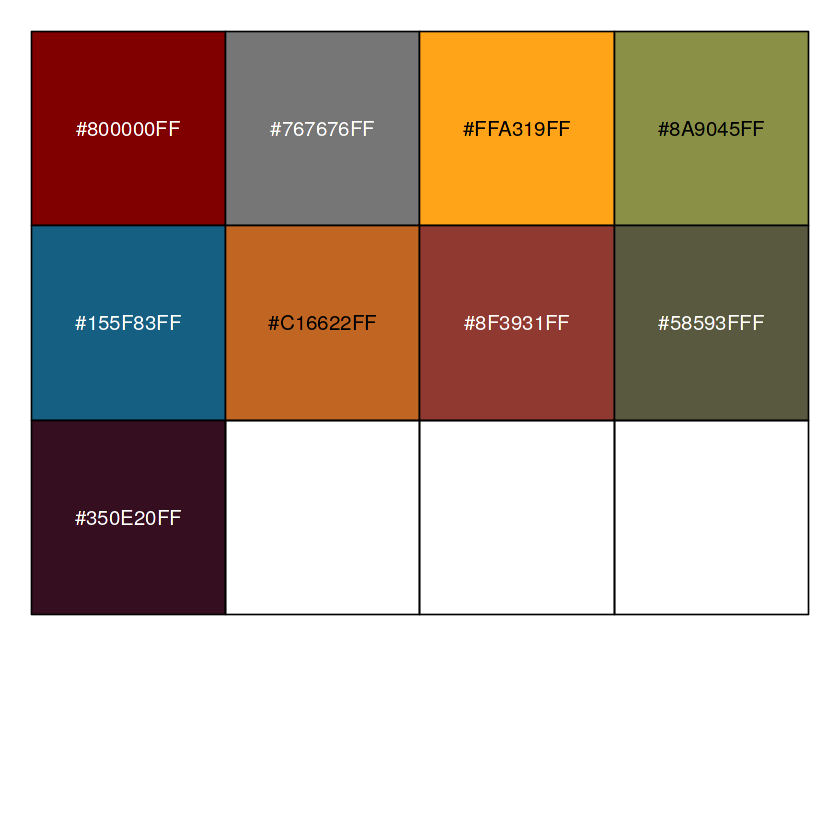

In [219]:
scales::show_col(pal_uchicago()(10))

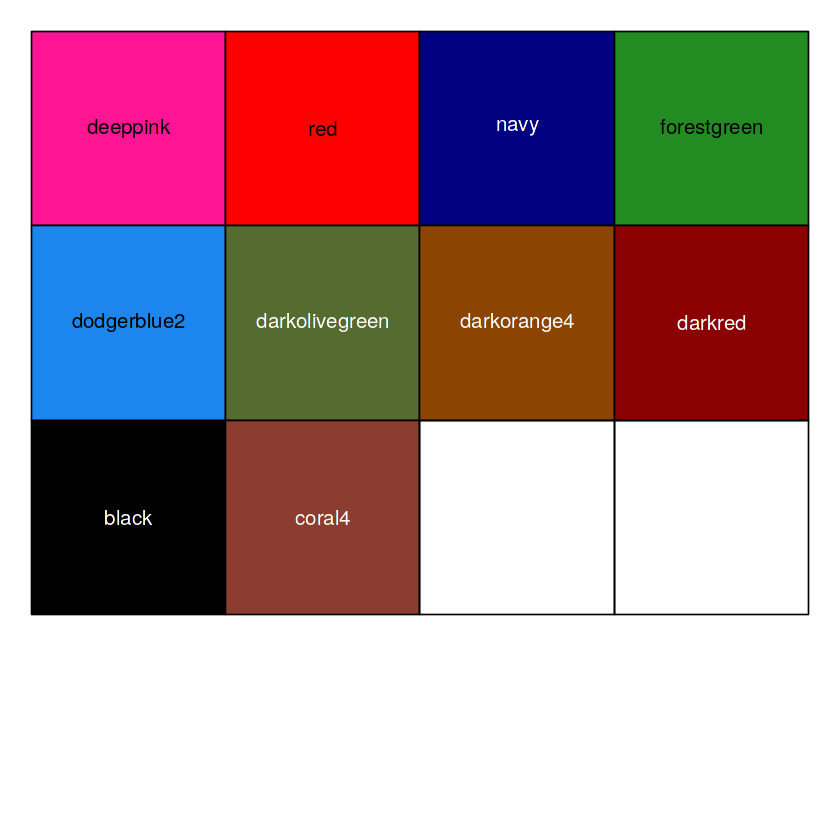

In [36]:
#anno_hmp_gene_cols <- brewer.pal(name = 'Paired', n = length(anno_hmp_genes))
#anno_hmp_gene_cols <- ggsci::pal_ucscgb()(length(anno_hmp_genes))
#anno_hmp_gene_cols <- ArchRPalettes$stallion[c(1:5,7,8,11,14,16:20)]
anno_hmp_gene_cols <- c('deeppink','red','navy','forestgreen','dodgerblue2','darkolivegreen','darkorange4','darkred','black','coral4')
names(anno_hmp_gene_cols) <- c('CC','Mito','HH','Wnt','mRNA','mRNA_splice','Chrom','GTPase','Nfkb','TyrKinase')

scales::show_col(anno_hmp_gene_cols)

#### ATAC heatmap

In [37]:
ATAC_hmp <- Heatmap(atac_mat, 
                    cluster_rows = FALSE, cluster_columns = FALSE, show_row_names = FALSE, show_column_names = FALSE,
                    split = clustered_p2g$ATAC$kmeansId, 
                    col = atac_color,
                    use_raster = TRUE, raster_quality = 5, raster_by_magick=TRUE,
                    top_annotation = ageAnno,
                    heatmap_legend_param = 
                    list(
                        at = c(0, 1),
                        title = "ATAC Z-Scores",
                        labels = c(round(min(limits),2), round(max(limits),2)),
                        color_bar = "continuous", 
                        legend_direction = "horizontal",
                        legend_width = unit(3, "cm")
                     ), 
                   rect_gp = gpar(col = NA))

#### RNA heatmap

In [38]:
RNA_hmp <- Heatmap(rna_mat, 
                   cluster_rows = FALSE, cluster_columns = FALSE, show_row_names = FALSE, show_column_names = FALSE,
                   split = clustered_p2g$RNA$kmeansId, 
                   col = rna_color,
                   use_raster = TRUE, raster_quality = 5, raster_by_magick=TRUE,
                   top_annotation = ageAnno,
                   heatmap_legend_param = 
                   list(
                      at = c(0, 1),
                      title = "RNA Z-Scores",
                      labels = c(round(min(limits),2), round(max(limits),2)),
                      color_bar = "continuous", 
                      legend_direction = "horizontal",
                      legend_width = unit(3, "cm")
                    ), 
                    rect_gp = gpar(col = NA))

#### Add row anno to heatmap

In [39]:
names(anno_hmp_gene_cols)

[1] "CC"          "Mito"        "HH"          "Wnt"         "mRNA"       
 [6] "mRNA_splice" "Chrom"       "GTPase"      "Nfkb"        "TyrKinase"

In [40]:
for (i in 1:length(anno_hmp_gene_cols)) {
    RNA_hmp <- RNA_hmp + 
      Heatmap(anno_hmp_gene_idx[[names(anno_hmp_gene_cols)[i]]], 
              name = names(anno_hmp_gene_cols)[i],
              col = c("0" = "transparent", "1" = anno_hmp_gene_cols[[names(anno_hmp_gene_cols)[i]]]), 
              use_raster = TRUE, raster_quality = 5, raster_by_magick=TRUE,
              cluster_columns = FALSE, cluster_rows = FALSE,
              show_column_names = TRUE, show_heatmap_legend = FALSE, width = unit(4, "mm"))
}
# for (i in 1:length(anno_hmp_genes)) {
#     RNA_hmp <- RNA_hmp + rowAnnotation(foo = anno_lines(anno_hmp_gene_idx[[i]], add_points = TRUE, gp = gpar(col = anno_hmp_gene_cols[[i]]), pt_gp = gpar(col = anno_hmp_gene_cols[[i]])))
# }

#### Assemble and plot heatmap

In [41]:
hmp_list <- ATAC_hmp + RNA_hmp

In [42]:
padding = 10
pdf(file.path(projdir,"output","Peak2GeneLinks","p2g_anno_hmp.pdf"), width=8, height=7)
draw(hmp_list, 
     padding = unit(c(padding, padding, padding, padding), "mm"),
     heatmap_legend_side = "bot", 
     annotation_legend_side = "bot")
dev.off()

No legend element is put in the last 2 rows under `nrow = 4`, maybe you
should set `by_row = FALSE`? Reset `nrow` to 2.

No legend element is put in the last 2 rows under `nrow = 4`, maybe you
should set `by_row = FALSE`? Reset `nrow` to 2.

Loading required namespace: magick

No legend element is put in the last 2 rows under `nrow = 4`, maybe you
should set `by_row = FALSE`? Reset `nrow` to 2.



png 
  2

In [134]:
marker_hmp_list <- lapply(1:length(anno_hmp_genes), function(i) {
    Heatmap(anno_hmp_gene_idx[[i]], 
            name = names(anno_hmp_gene_idx)[i],
            height = length(anno_hmp_gene_idx[[i]])*unit(0.01, "mm"),
            col = c("0" = "transparent", "1" = anno_hmp_gene_cols[[i]]), 
            use_raster = TRUE, raster_quality = 5, raster_by_magick=TRUE,
            cluster_columns = FALSE, cluster_rows = FALSE,
            show_column_names = TRUE, show_heatmap_legend = FALSE, width = unit(4, "mm"))
})

In [131]:
length(anno_hmp_gene_idx[[1]])*0.025

[1] 1638.4

In [133]:
padding = 15
svg(file.path(projdir,"output","Peak2GeneLinks","p2g_anno_marker_hmp.svg"), width=6, height=65)
draw(Reduce('+', marker_hmp_list),
     padding = unit(c(padding, padding, padding, padding), "mm"),
     heatmap_legend_side = "bot", 
     annotation_legend_side = "bot")
dev.off()

png 
  2

In [191]:
tmp <- Heatmap(anno_hmp_gene_idx[[i]], 
            name = names(anno_hmp_gene_idx)[i],
            height = length(anno_hmp_gene_idx[[i]])*unit(0.01, "mm"),
            col = c("0" = "transparent", "1" = anno_hmp_gene_cols[[i]]), 
            use_raster = TRUE, raster_quality = 5, raster_by_magick=TRUE,
            cluster_columns = FALSE, cluster_rows = FALSE,
            show_column_names = TRUE, show_heatmap_legend = FALSE, width = unit(4, "mm"))
draw(tmp)

In [174]:
df <- data.frame(idx = factor(1:length(anno_hmp_gene_idx[[i]])),
                 value = as.integer(anno_hmp_gene_idx[[i]]))
str(df)

'data.frame':	65536 obs. of  2 variables:
 $ idx  : Factor w/ 65536 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ value: int  0 0 0 0 0 0 0 0 0 0 ...


In [181]:
prop.table(table(anno_hmp_gene_idx[[1]], clustered_p2g$RNA$kmeansId), margin = 2)

   
               1            2            3            4            5
  0 0.9884137701 0.9802819679 0.9821336761 0.9973127601 0.9998375832
  1 0.0115862299 0.0197180321 0.0178663239 0.0026872399 0.0001624168

In [164]:
model <- glm(value ~ idx, data=df, family=binomial)

In [165]:
df$predicted_value = predict(model, df, type="response")

In [253]:
length(unique(clustered_p2g$Peak2GeneLinks$idxRNA))

[1] 10497